In [2]:
import yerbamate, pandas as pd, os
env = yerbamate.Environment()

hashtags_path = os.path.join(env["plots"], "analysis", "hashtag.parquet")

df = pd.read_parquet(hashtags_path)
df.head()

year  month  day          hashtag  count
0  2022     12   31       مهسا_امینی  79665
1  2022     12   31  اعتصابات_سراسری  14601
2  2022     12   31   IranRevolution  14416
3  2022     12   31       MahsaAmini  13174
4  2022     12   31          جوانرود   9816

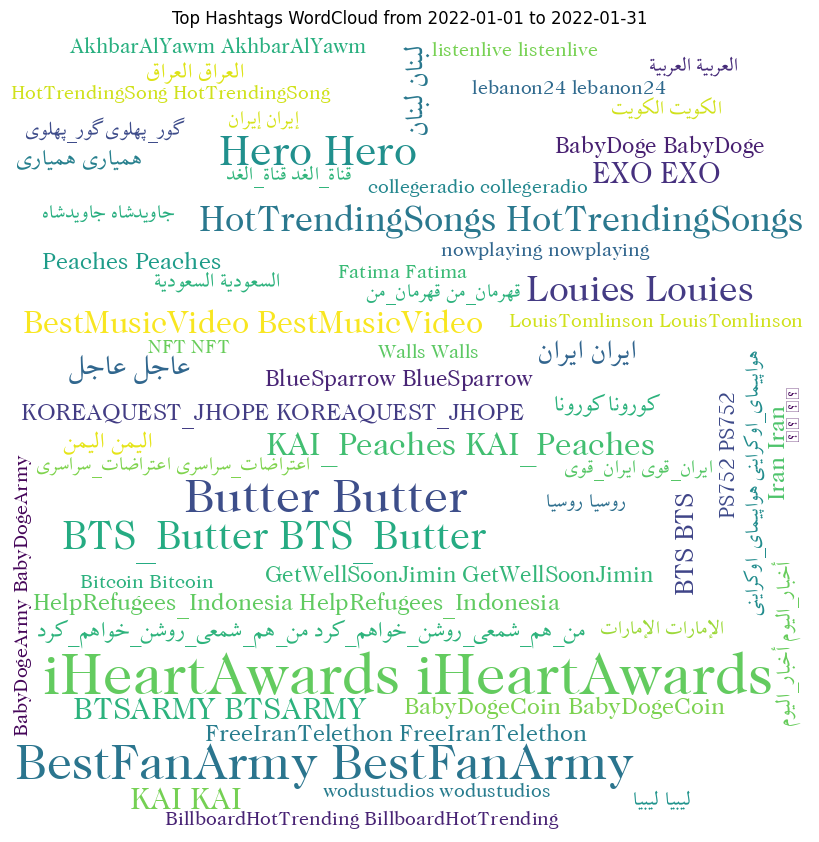

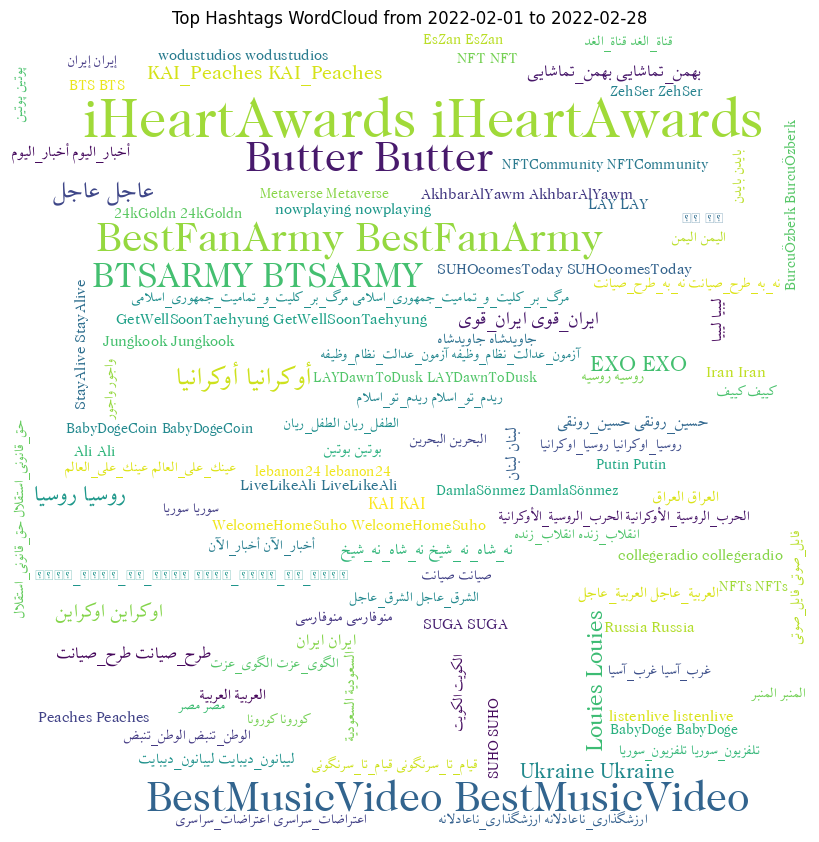

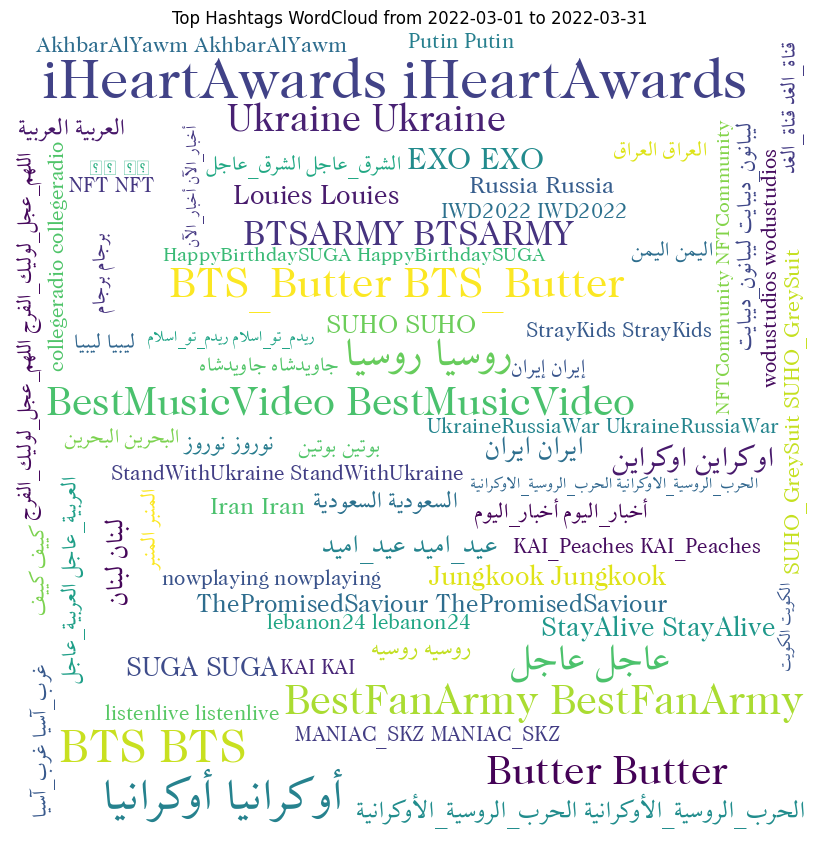

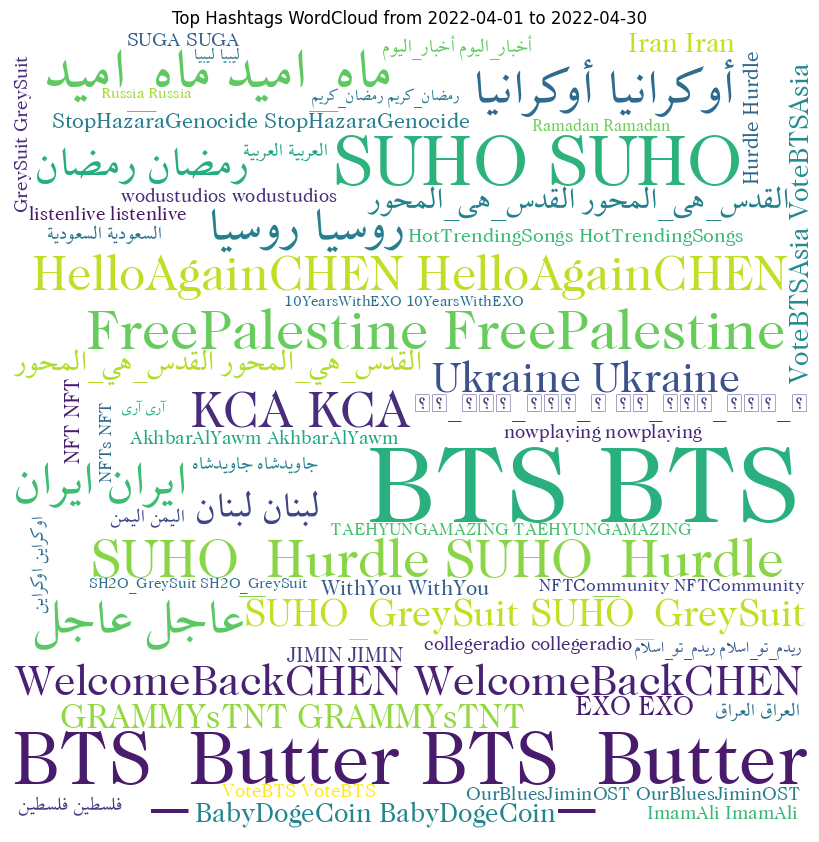

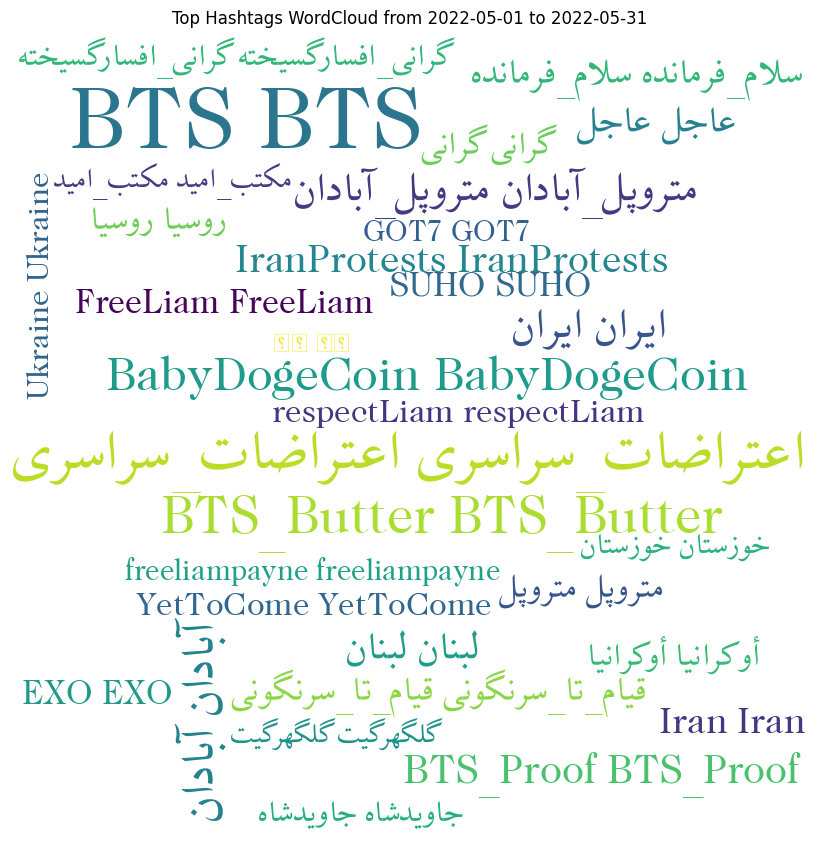

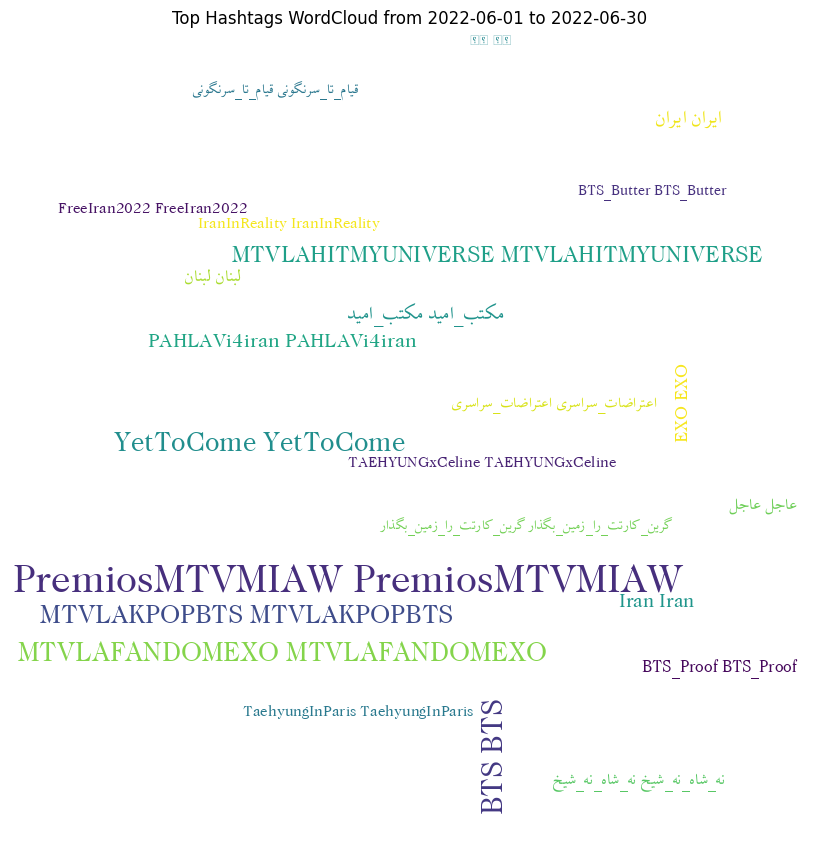

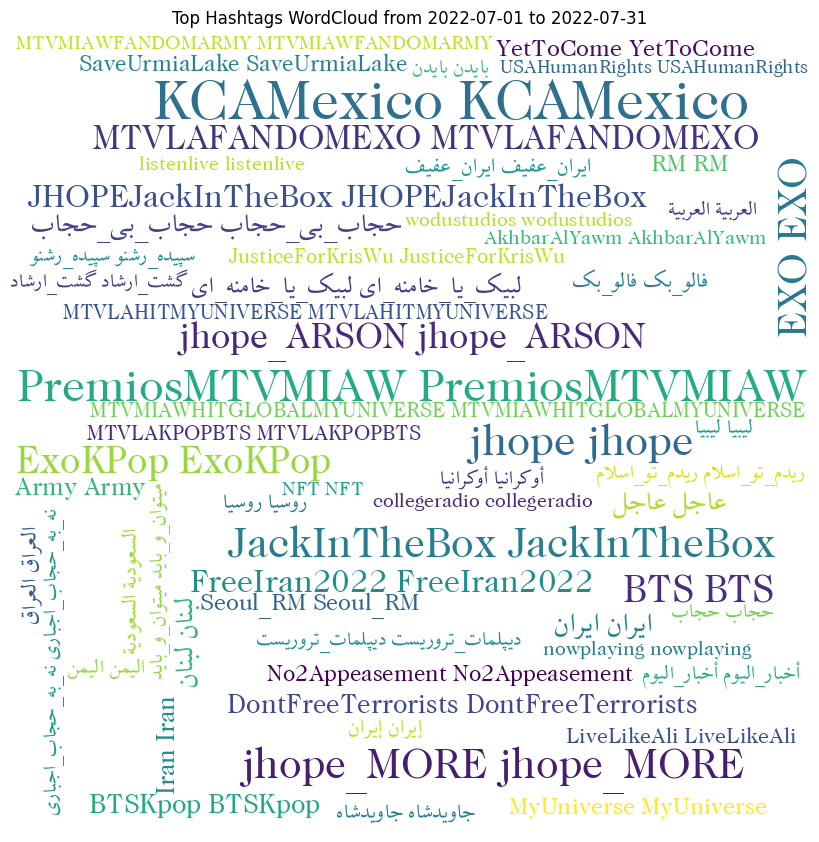

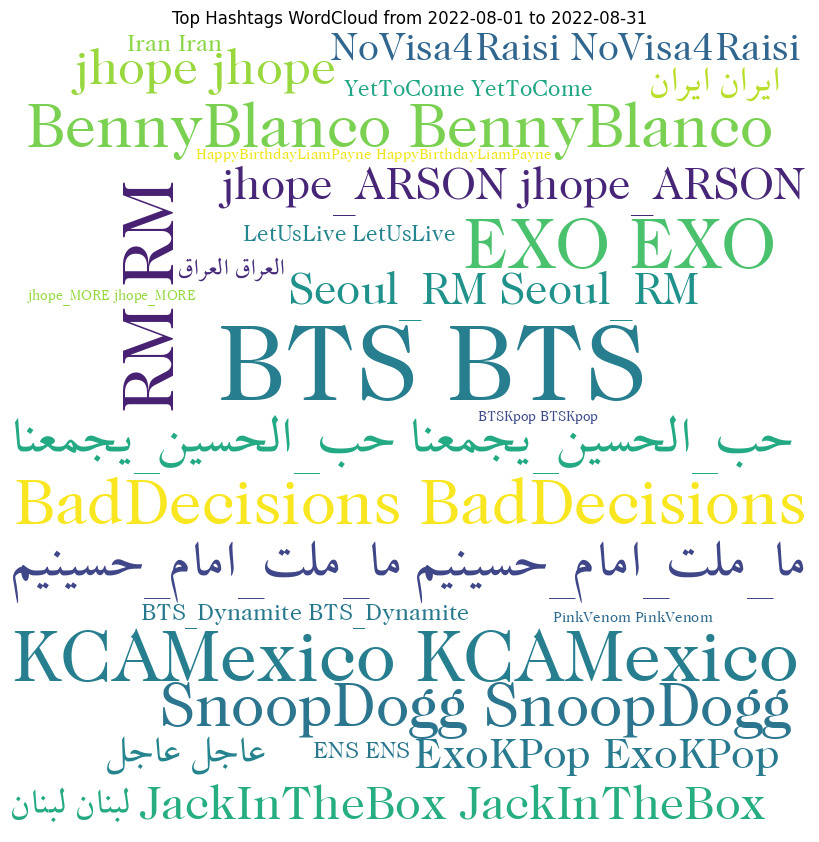

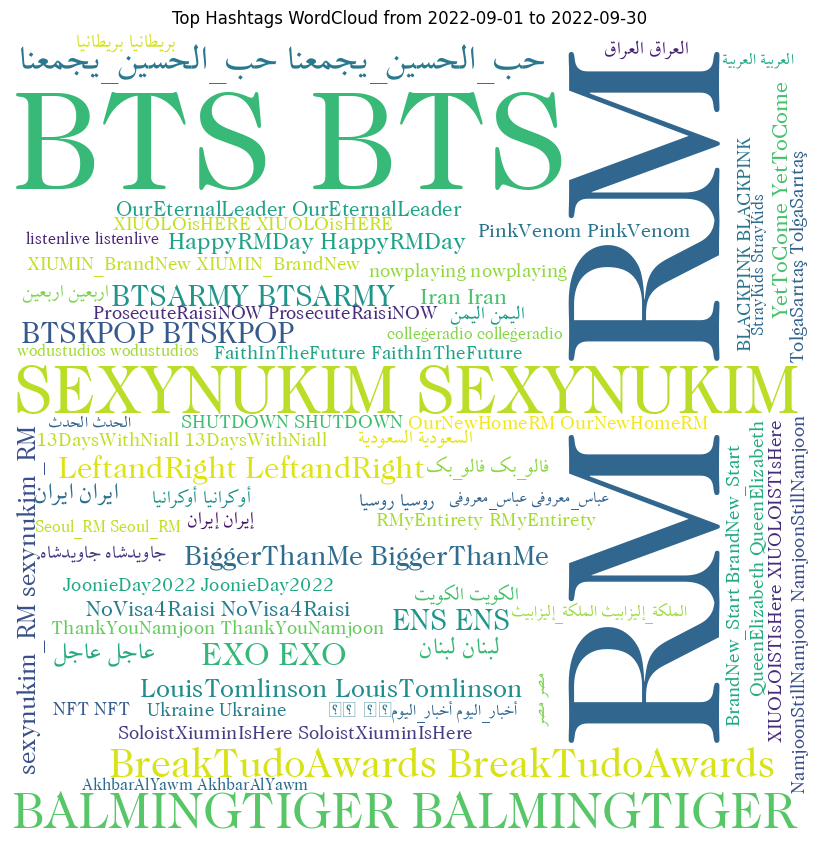

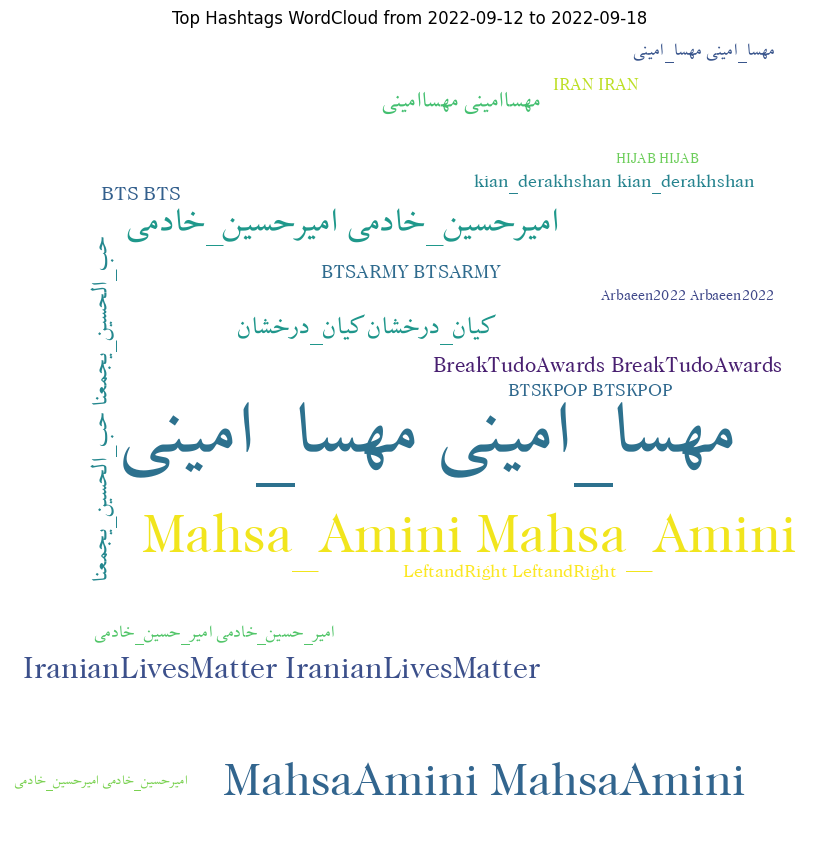

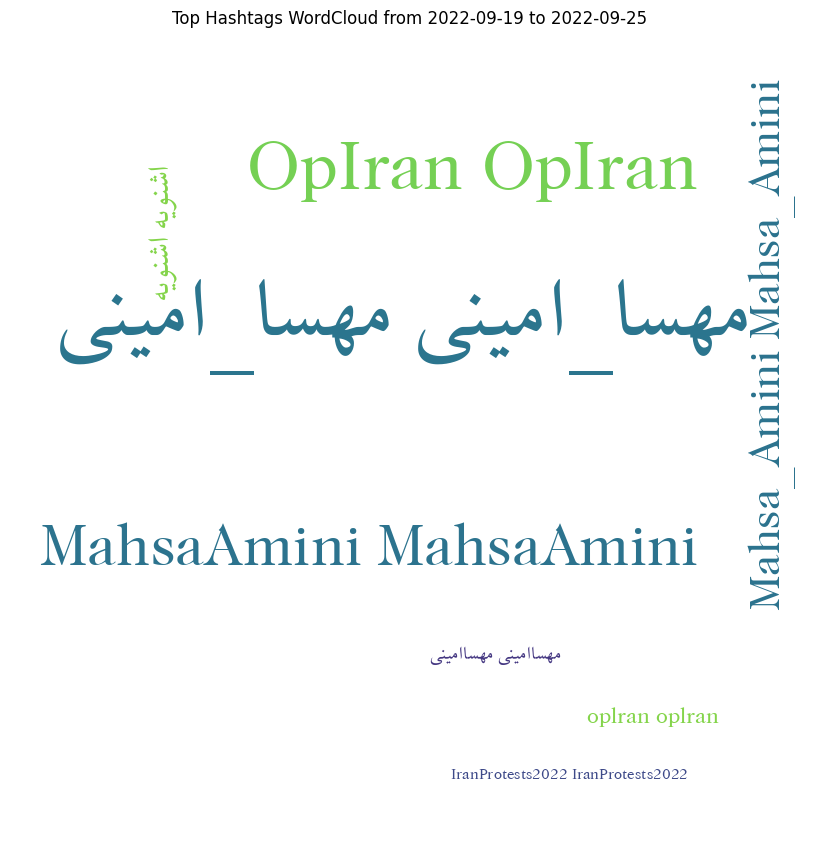

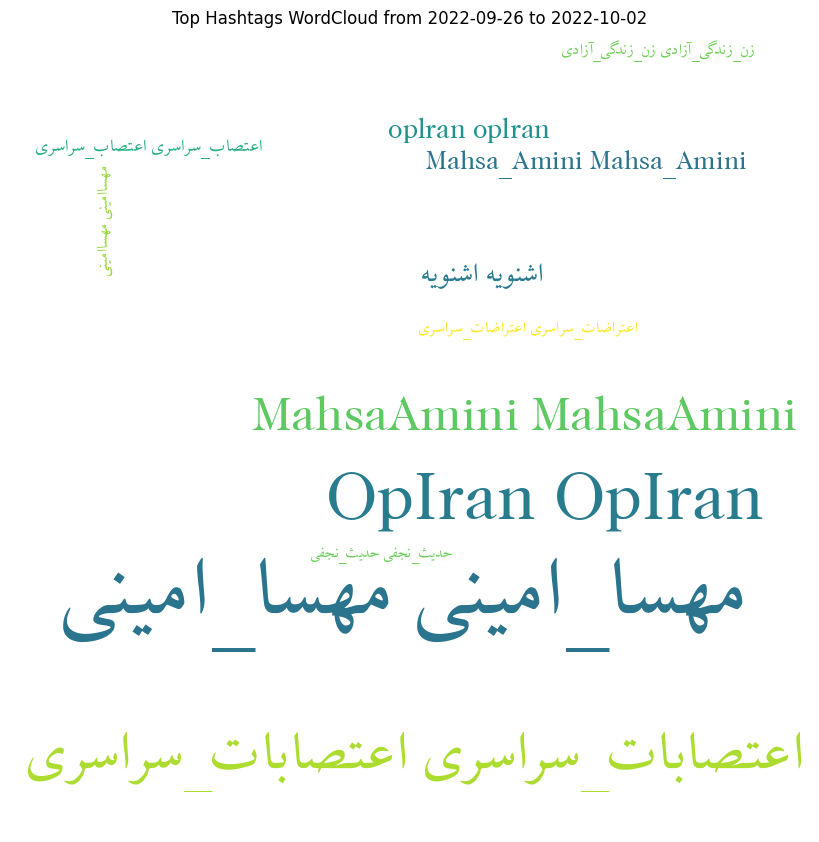

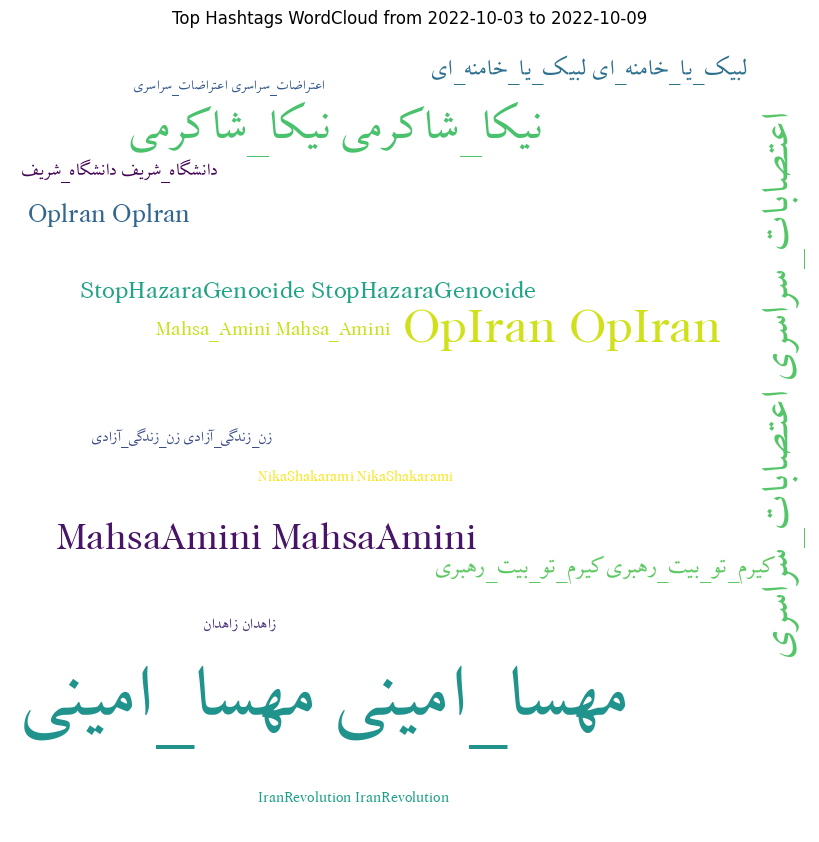

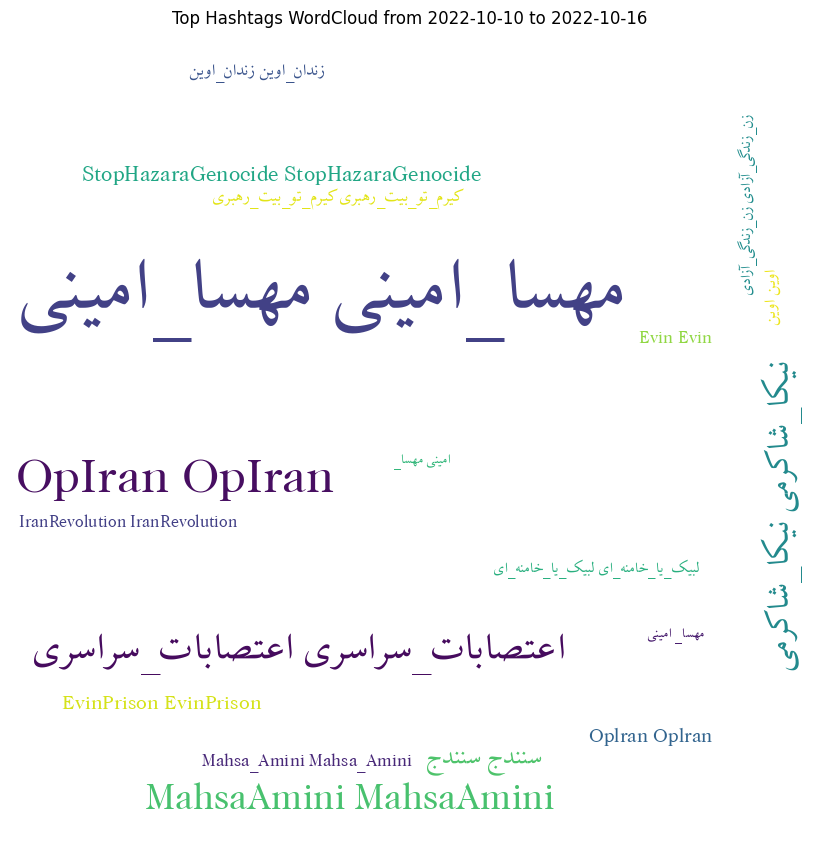

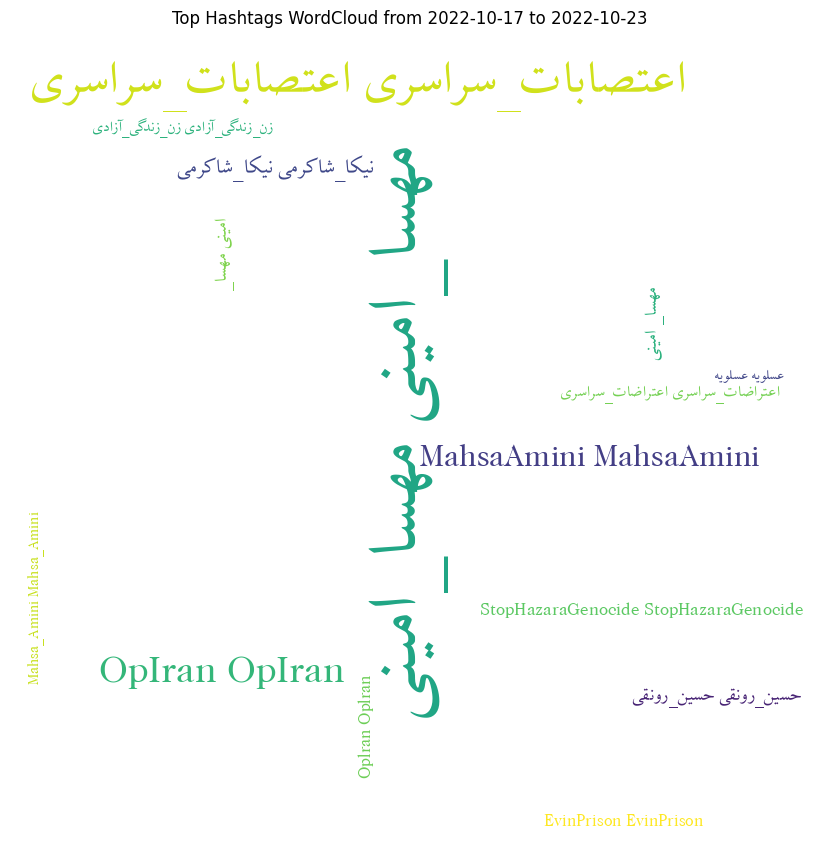

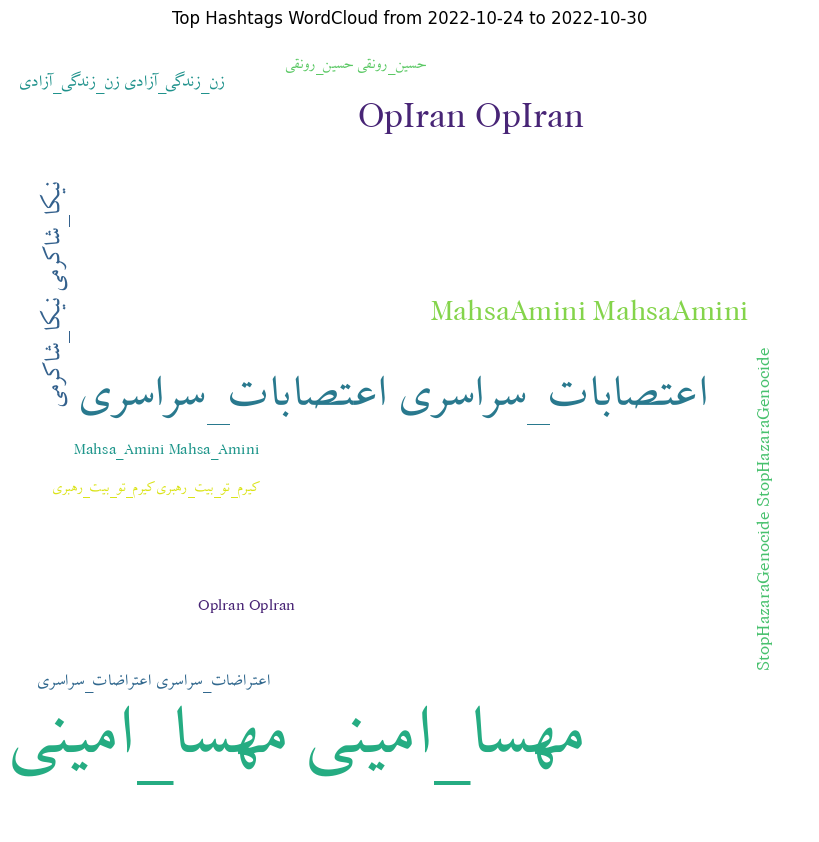

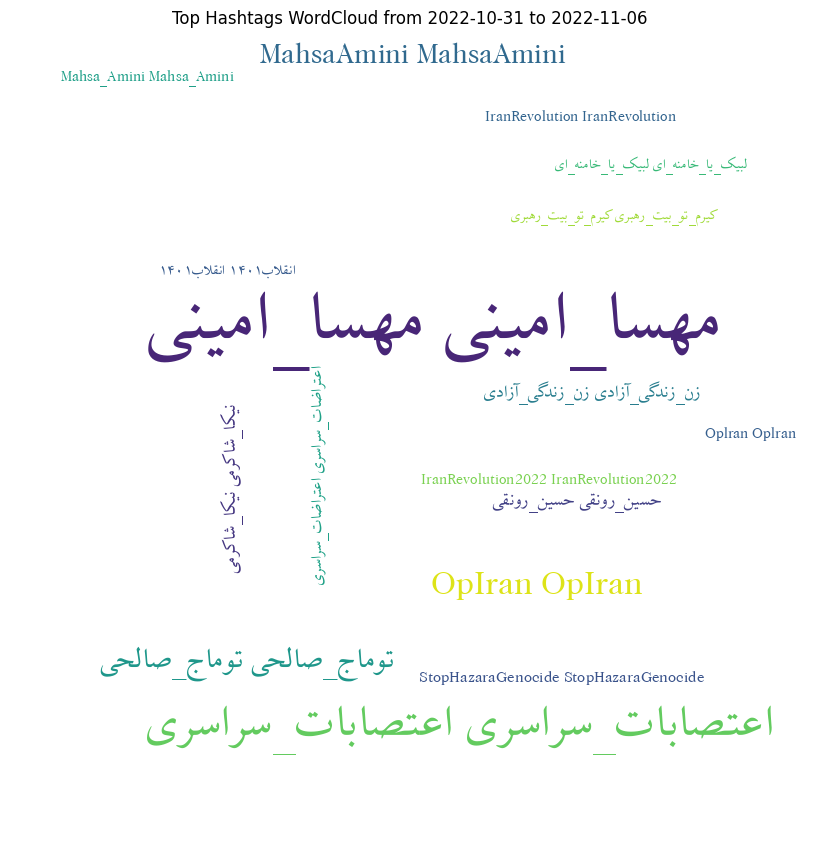

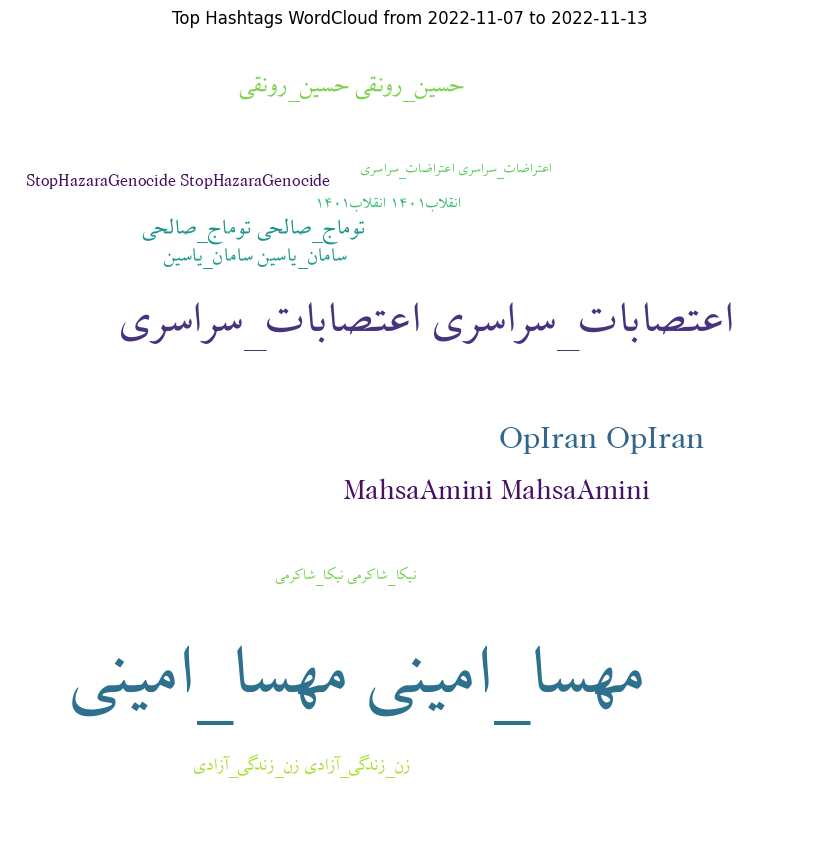

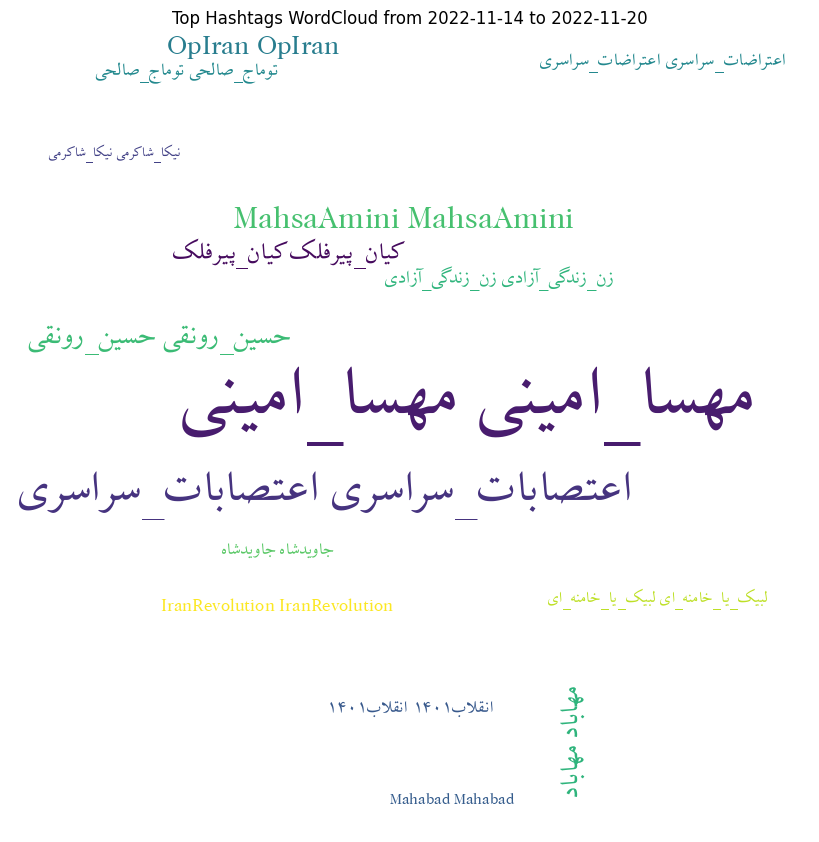

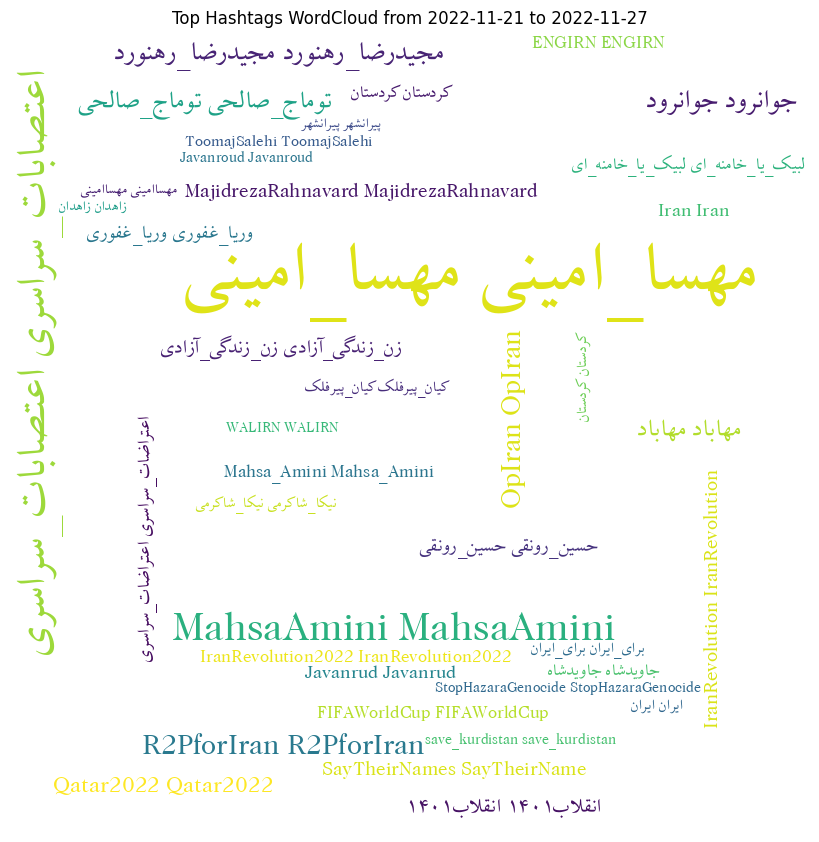

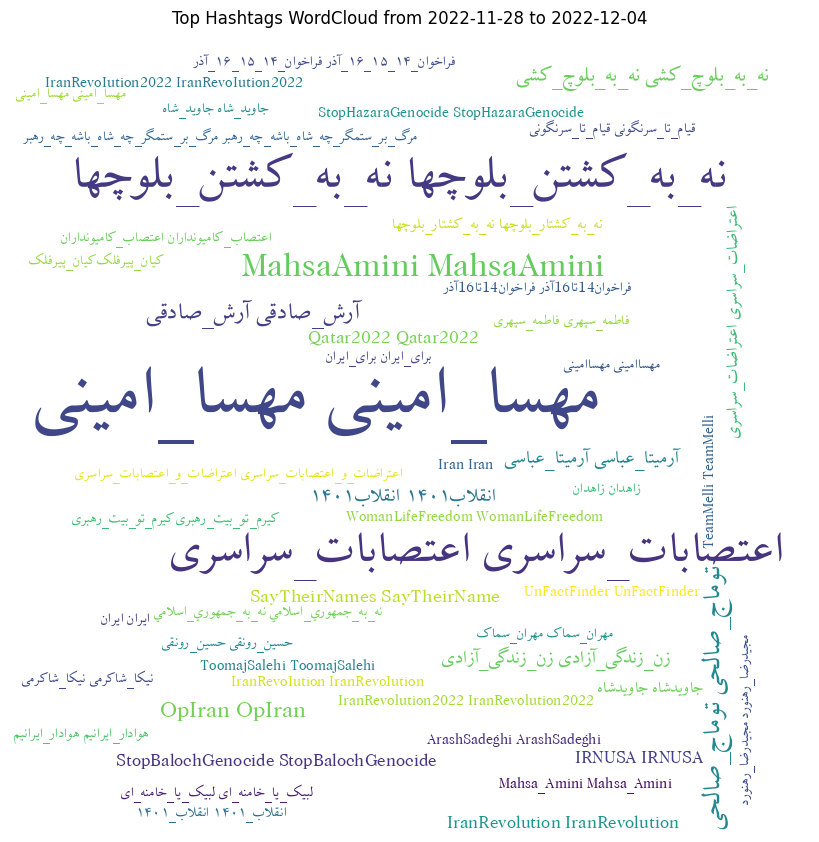

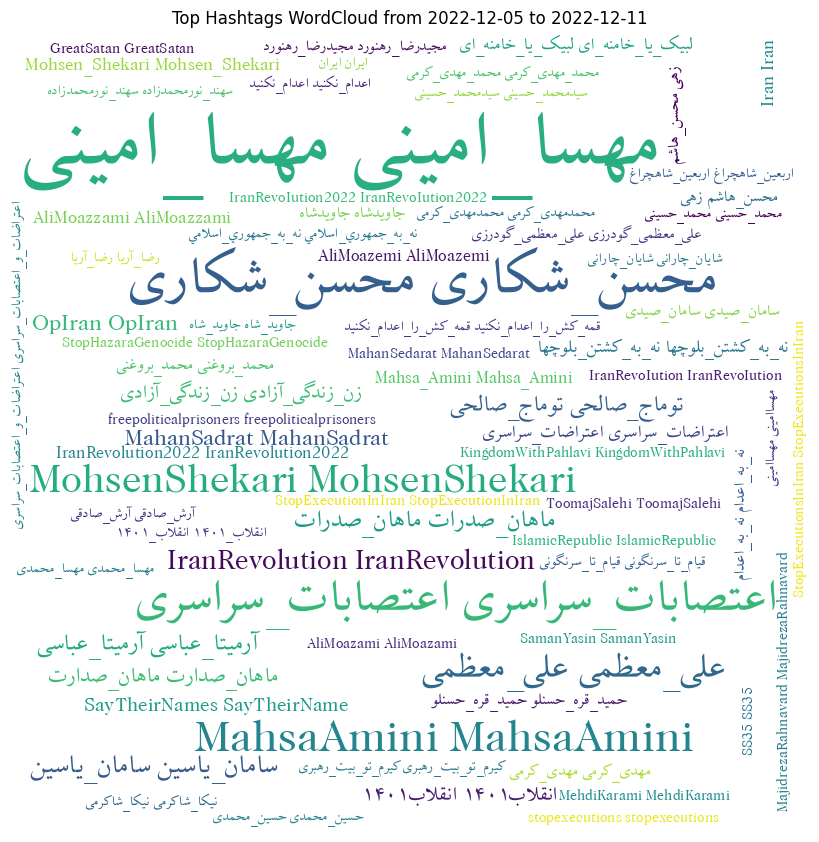

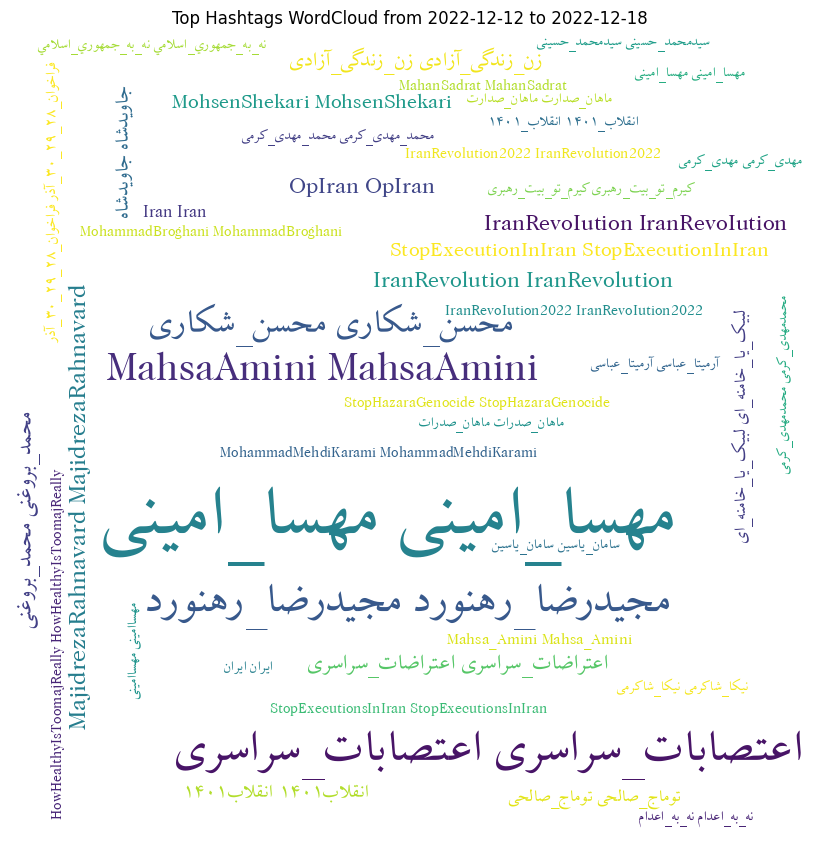

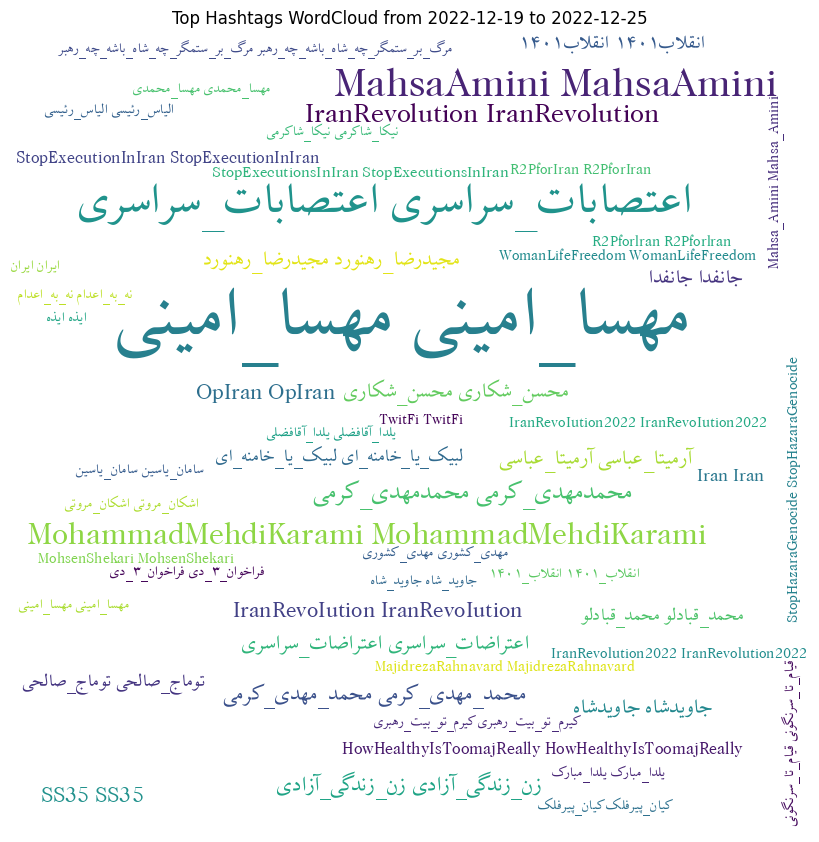

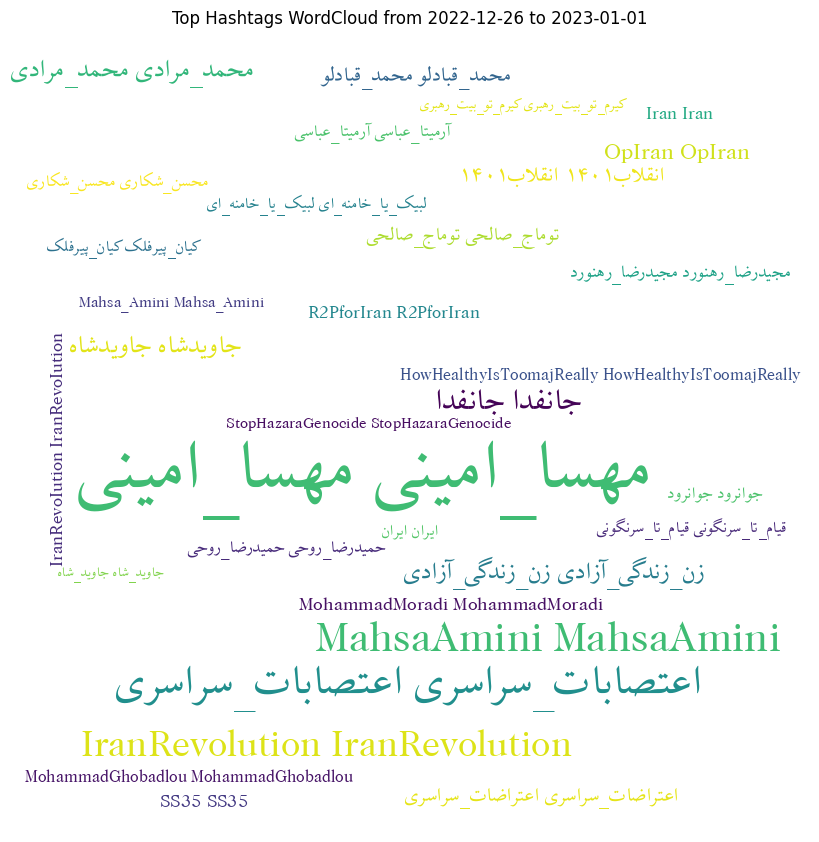

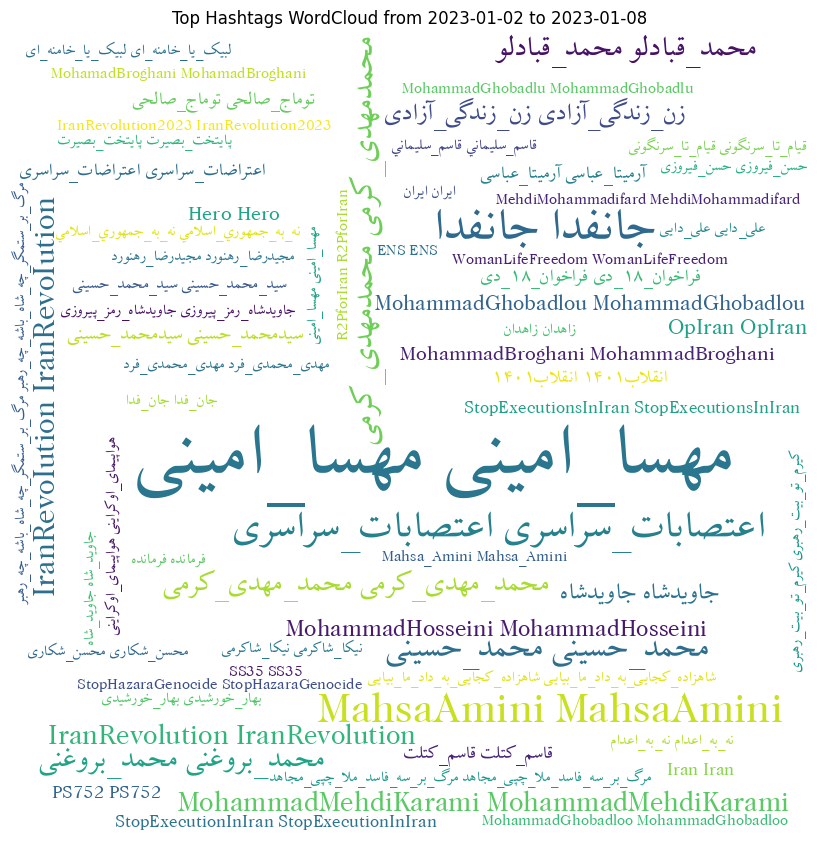

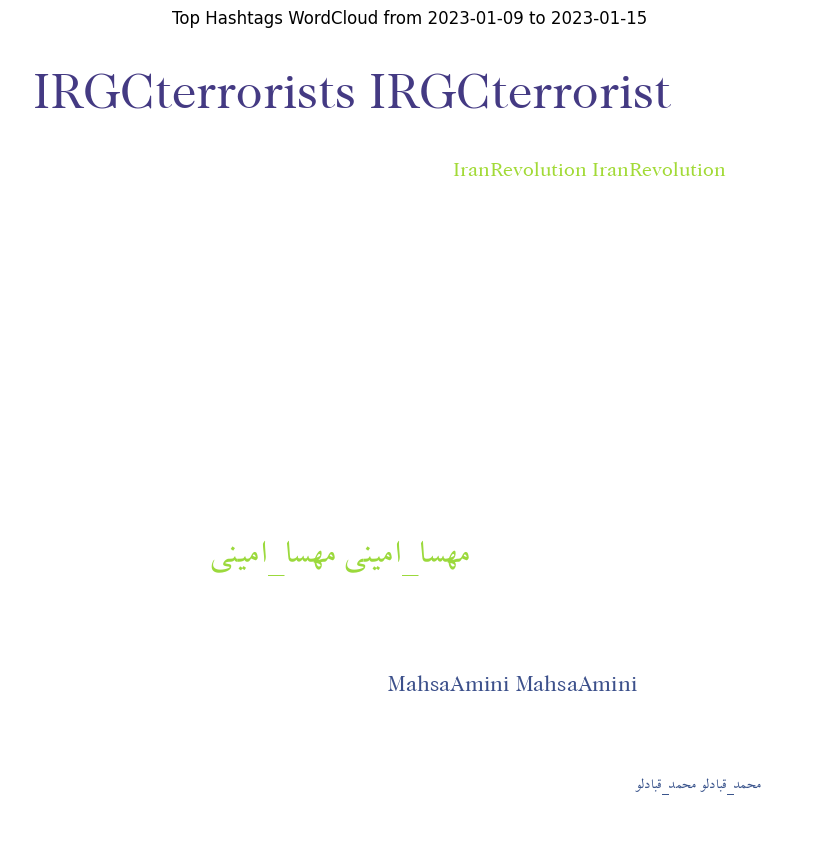

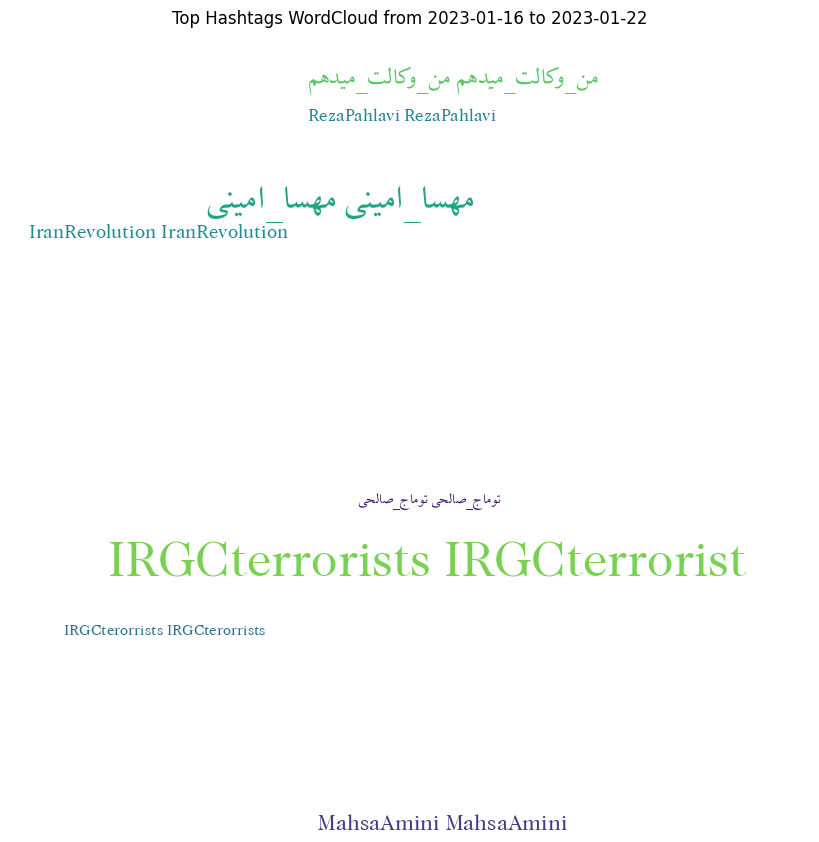

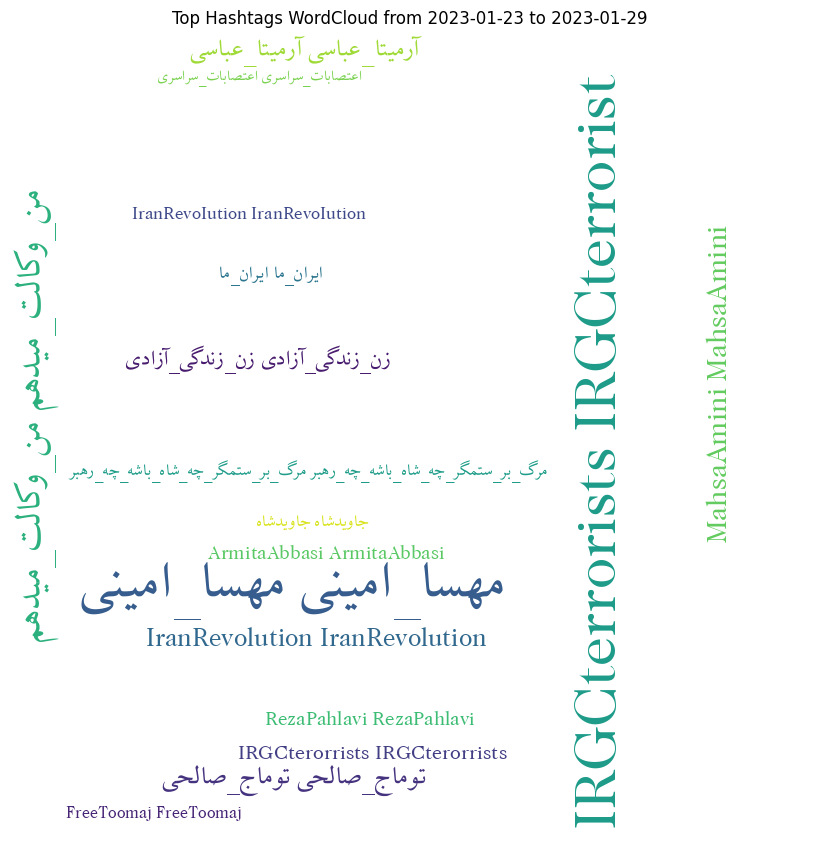

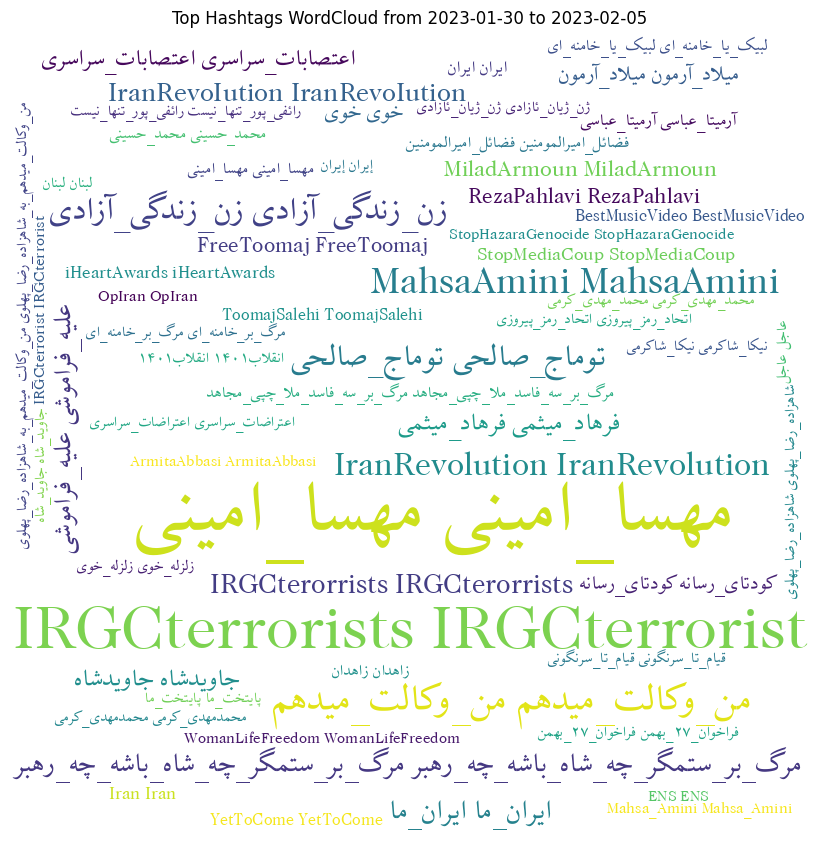

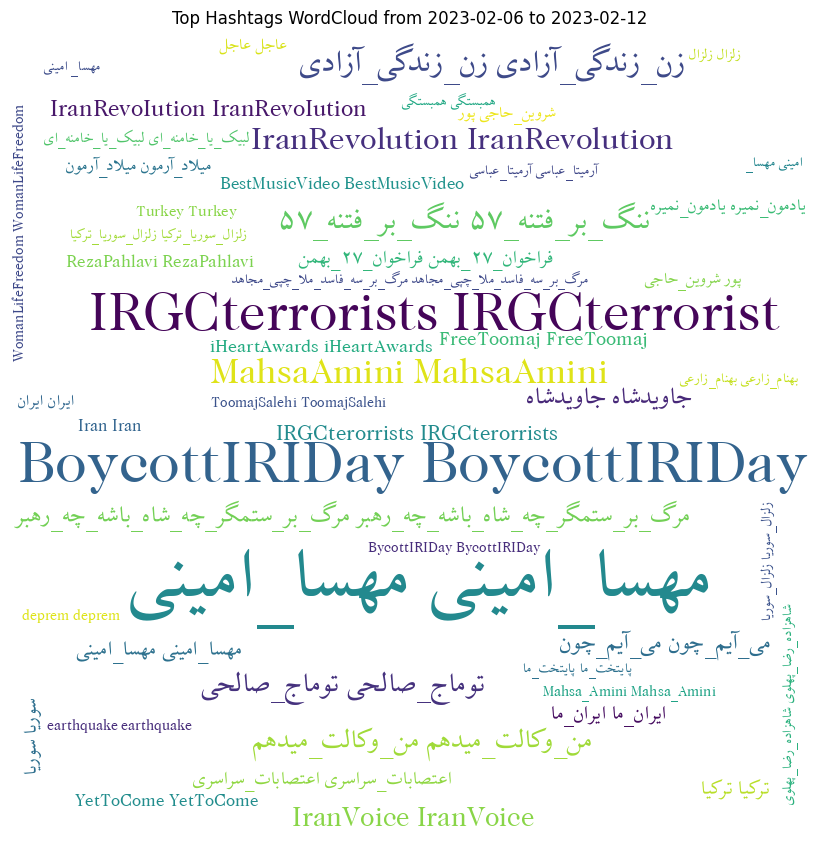

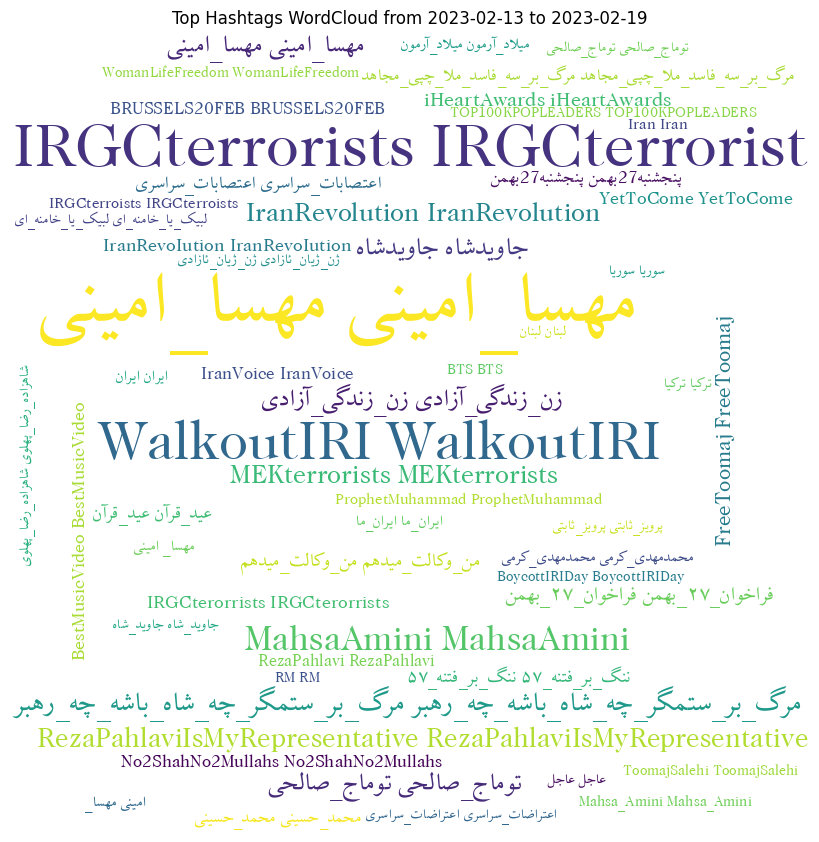

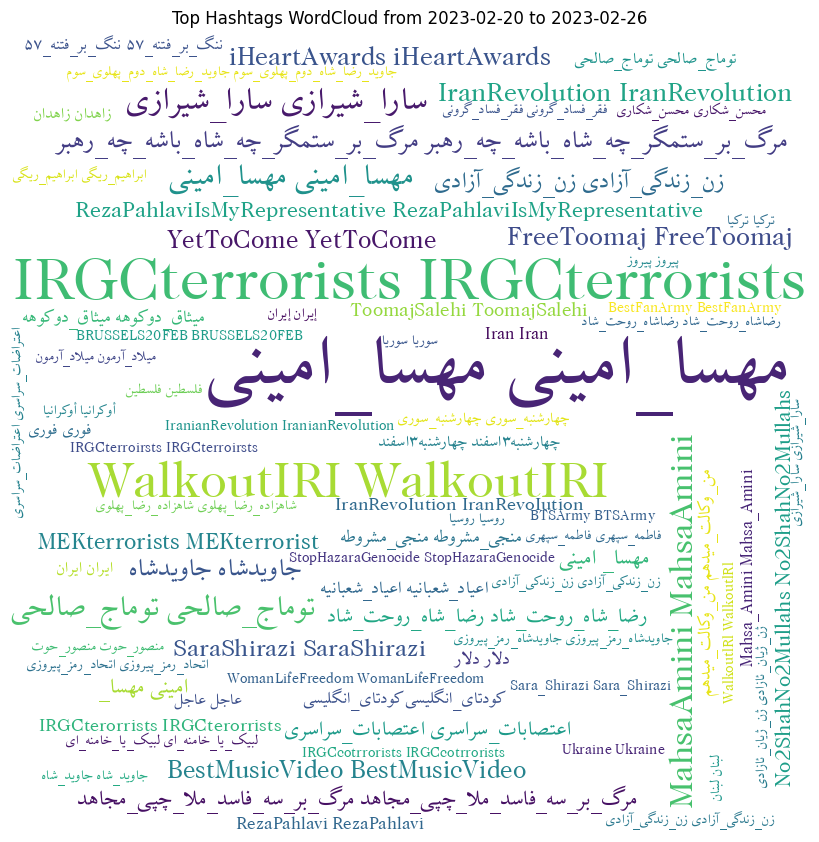

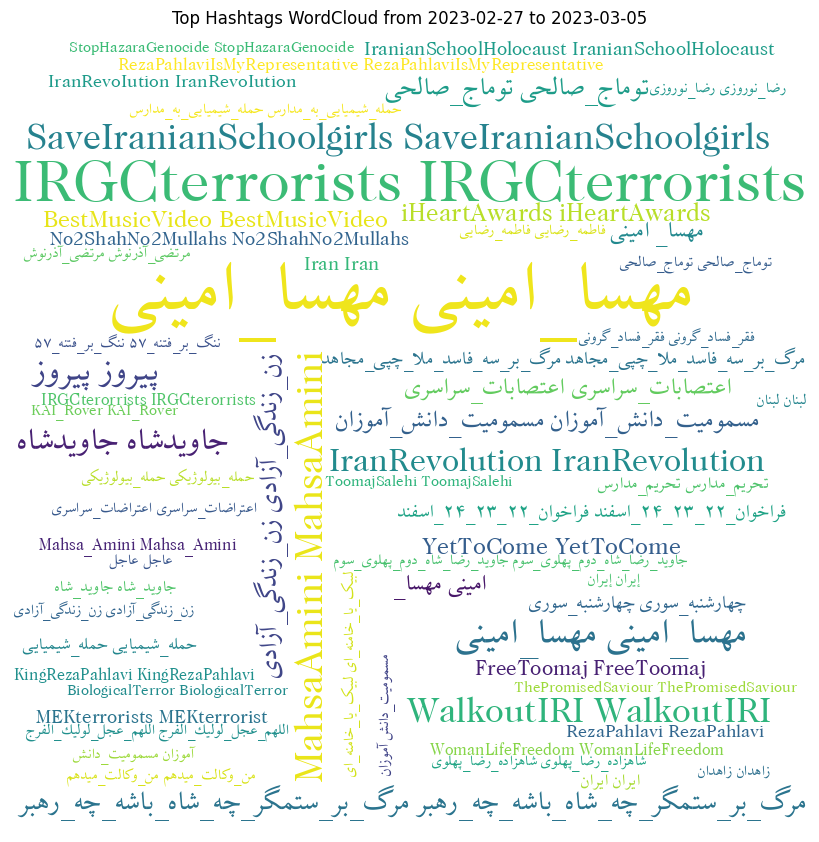

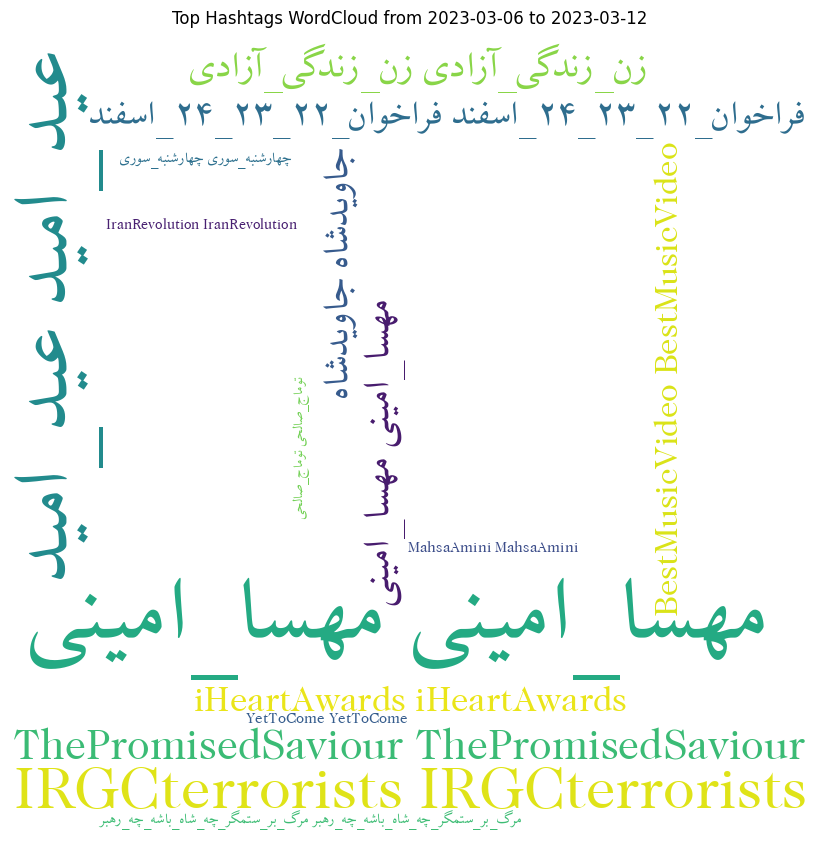

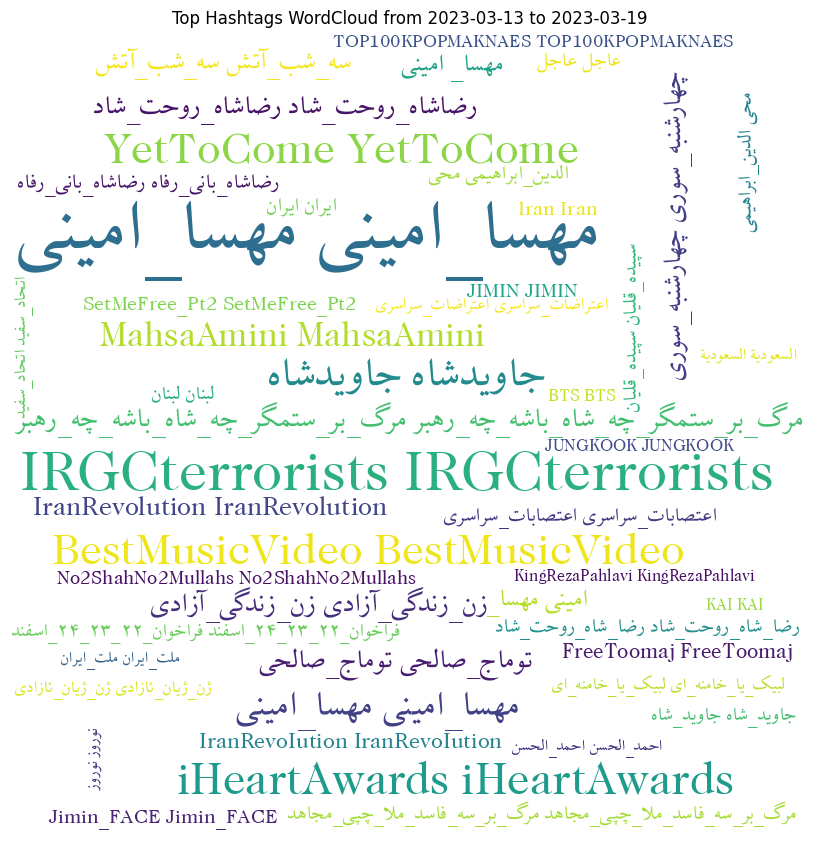

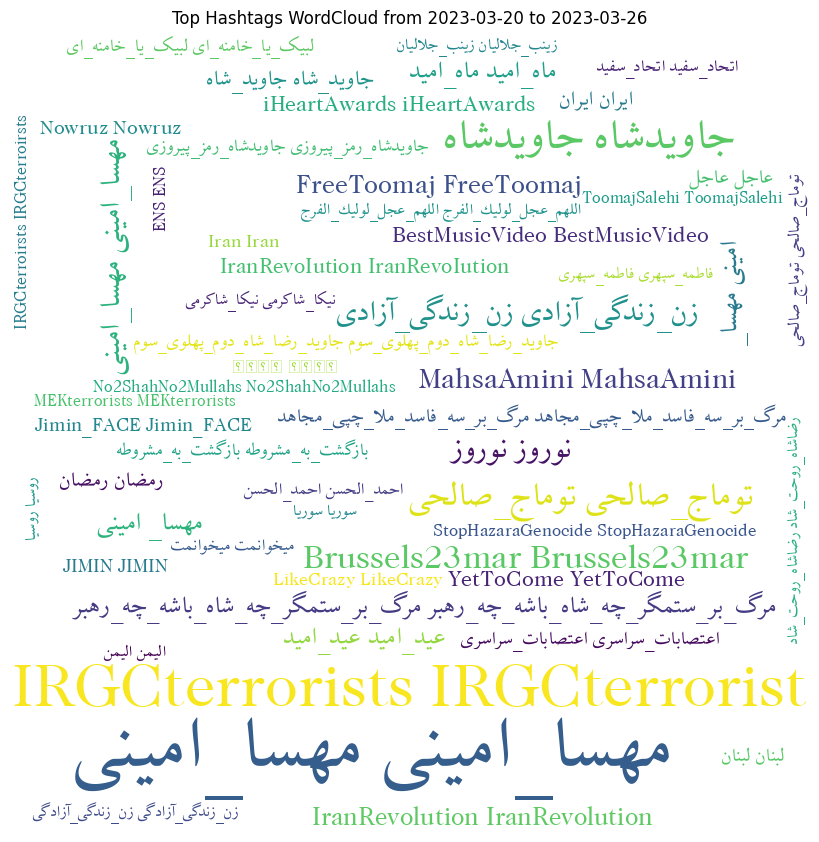

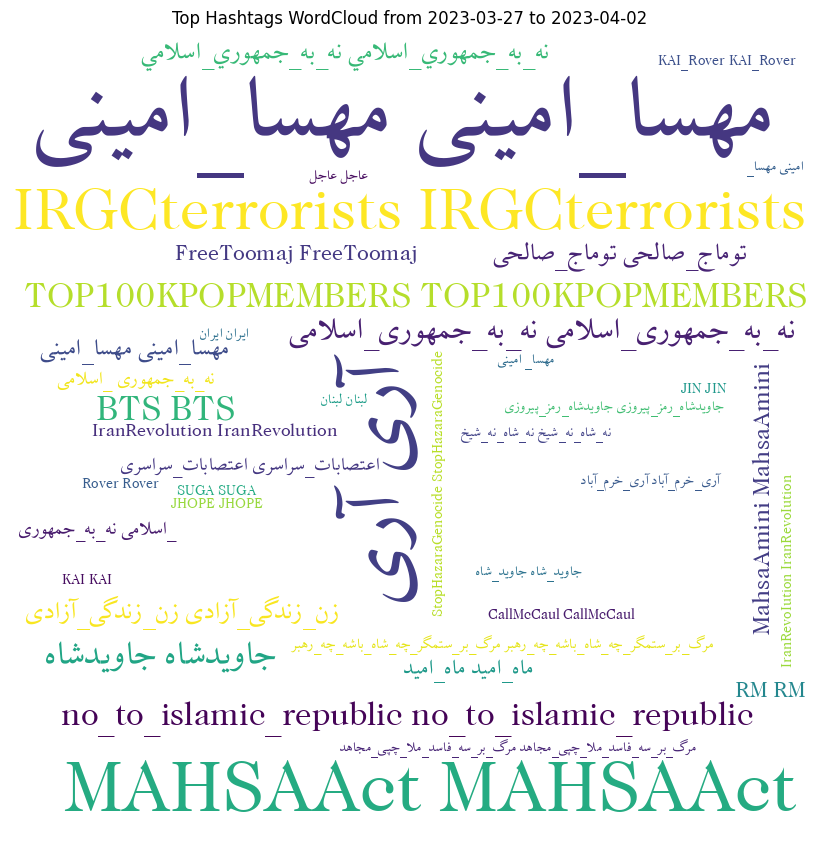

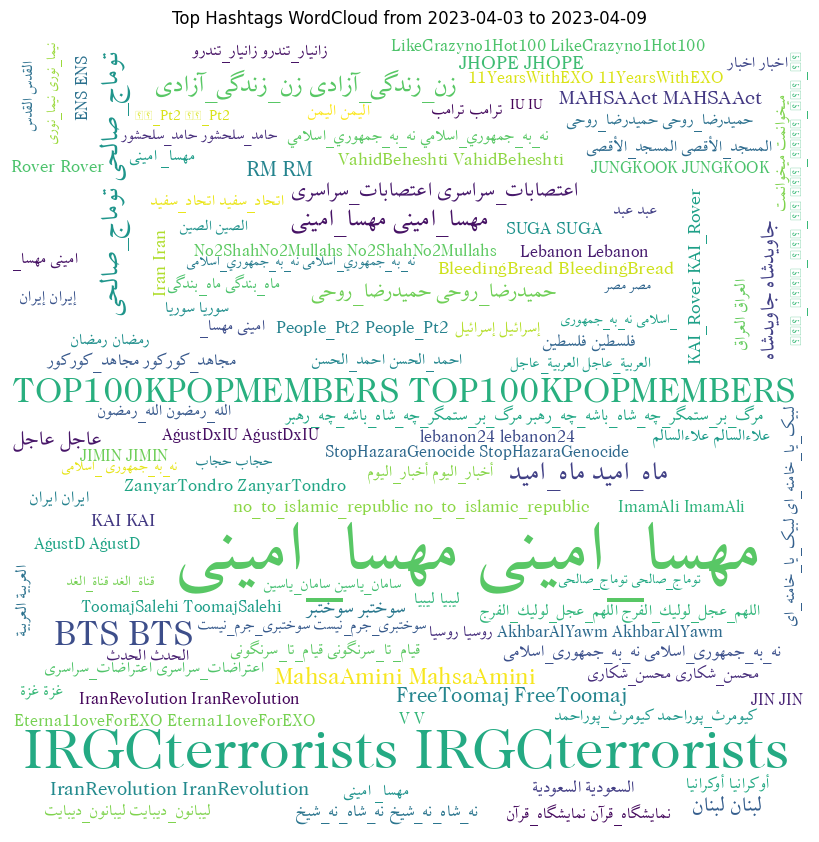

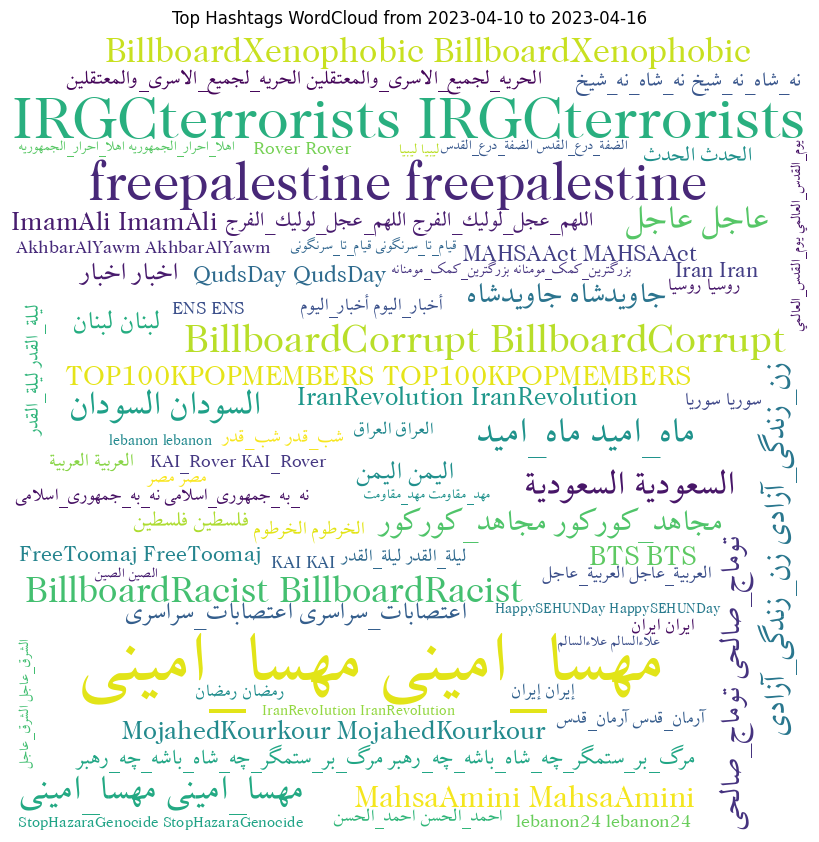

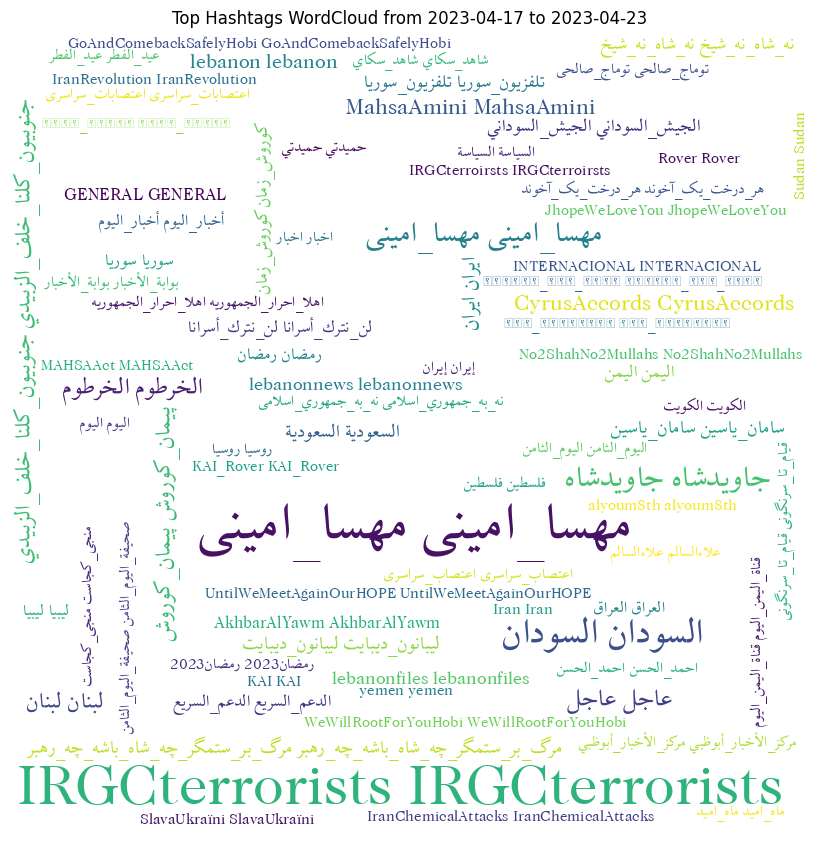

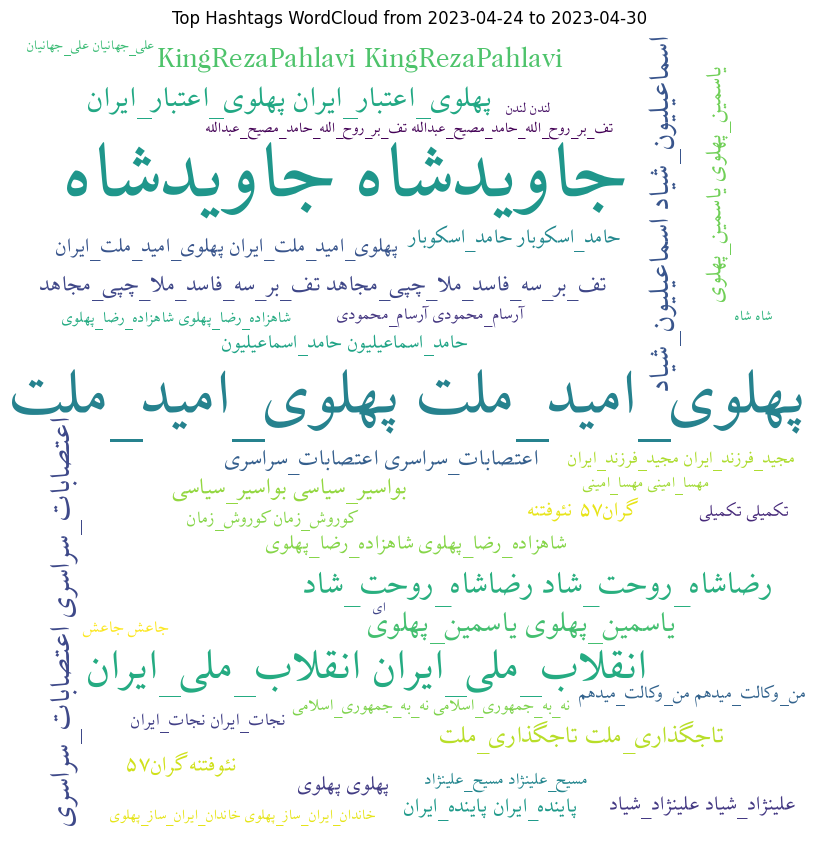

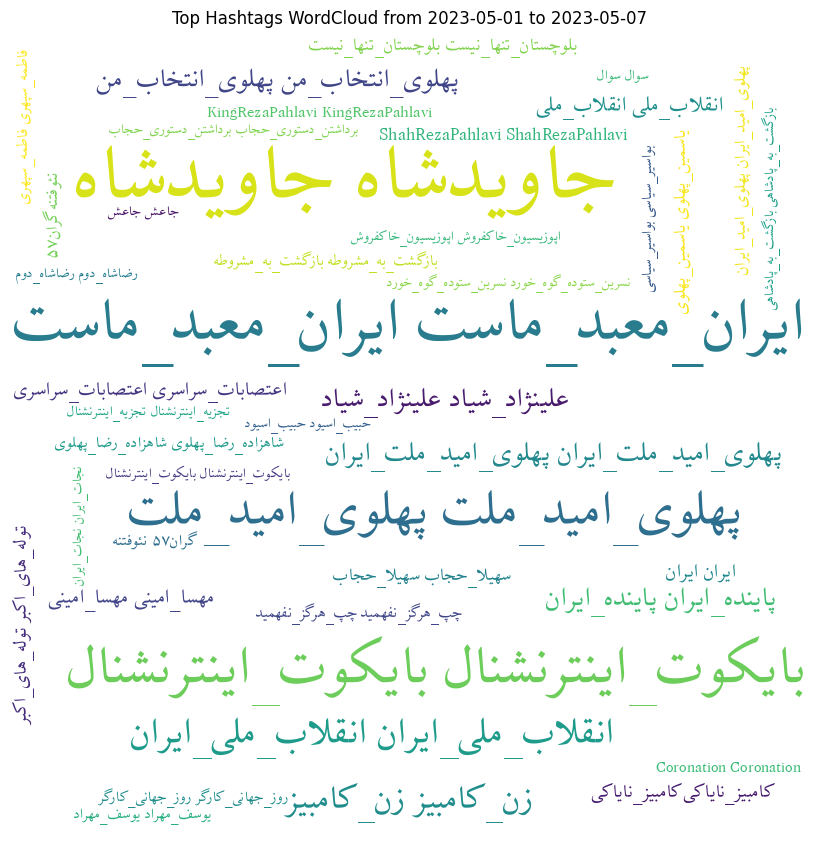

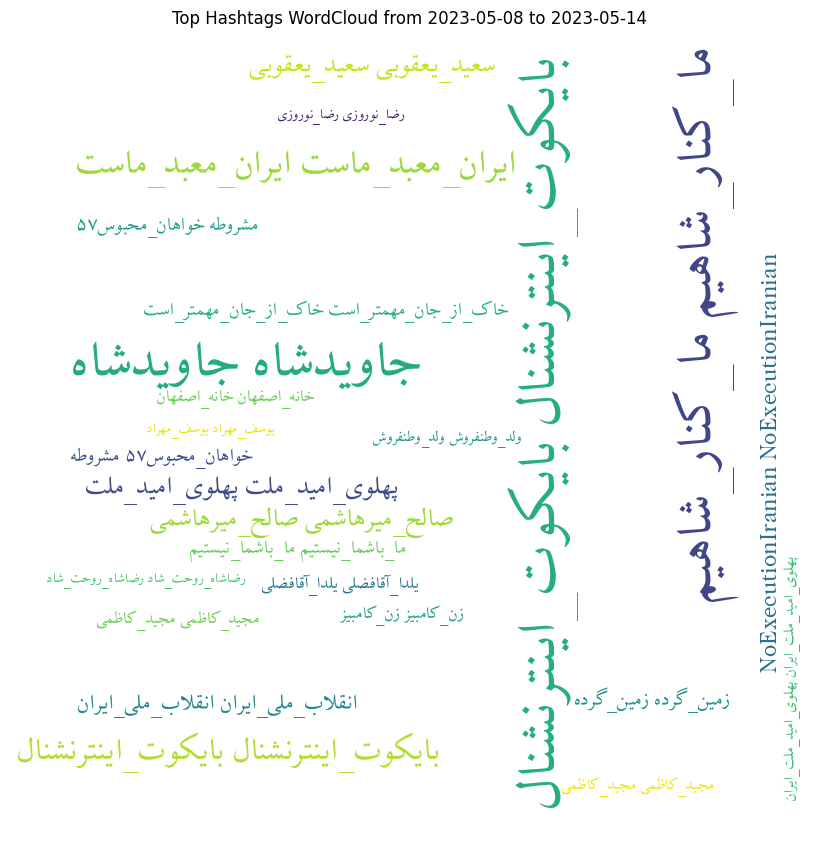

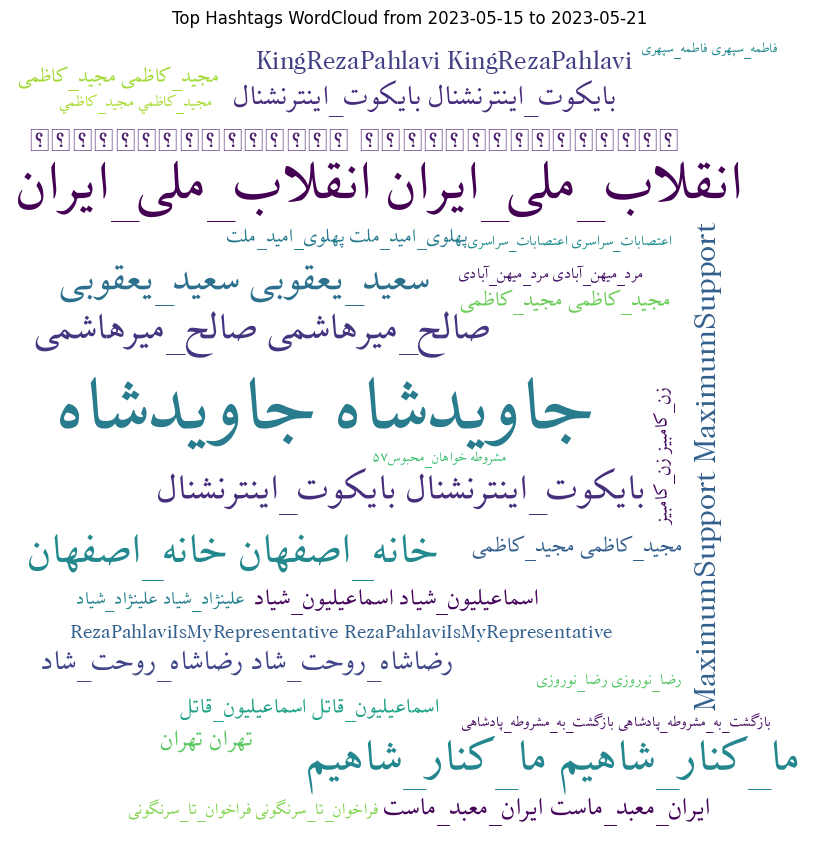

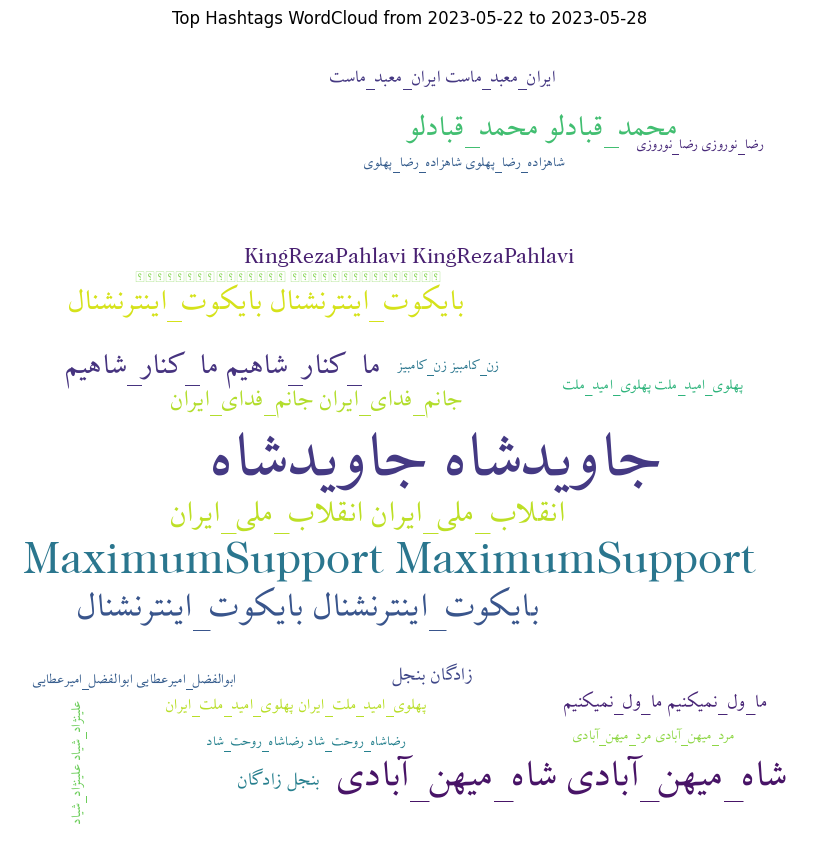

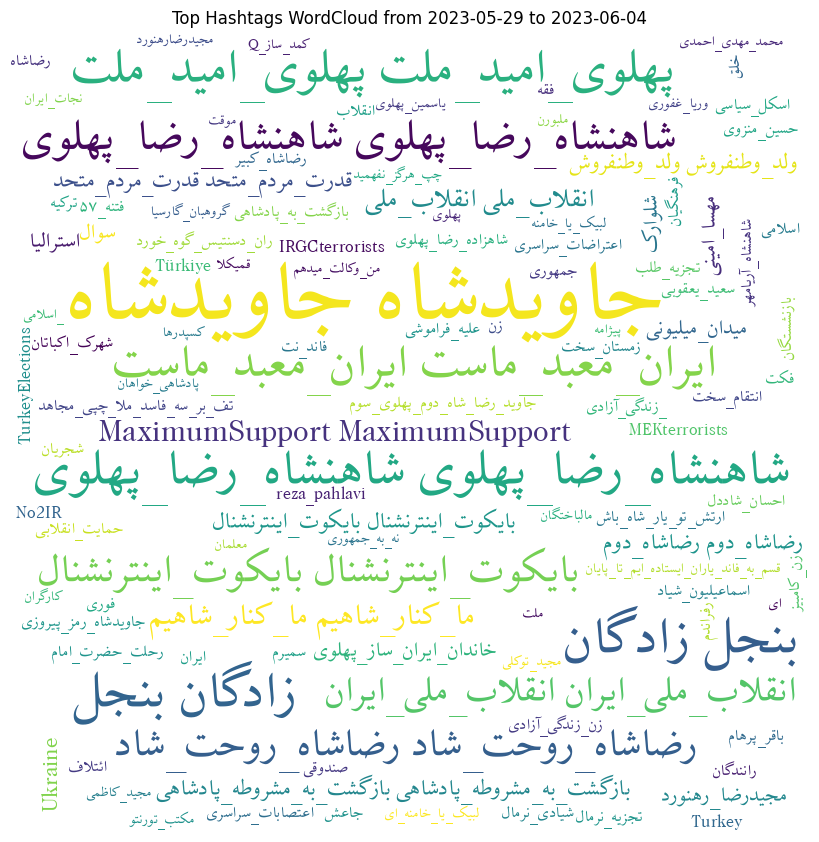

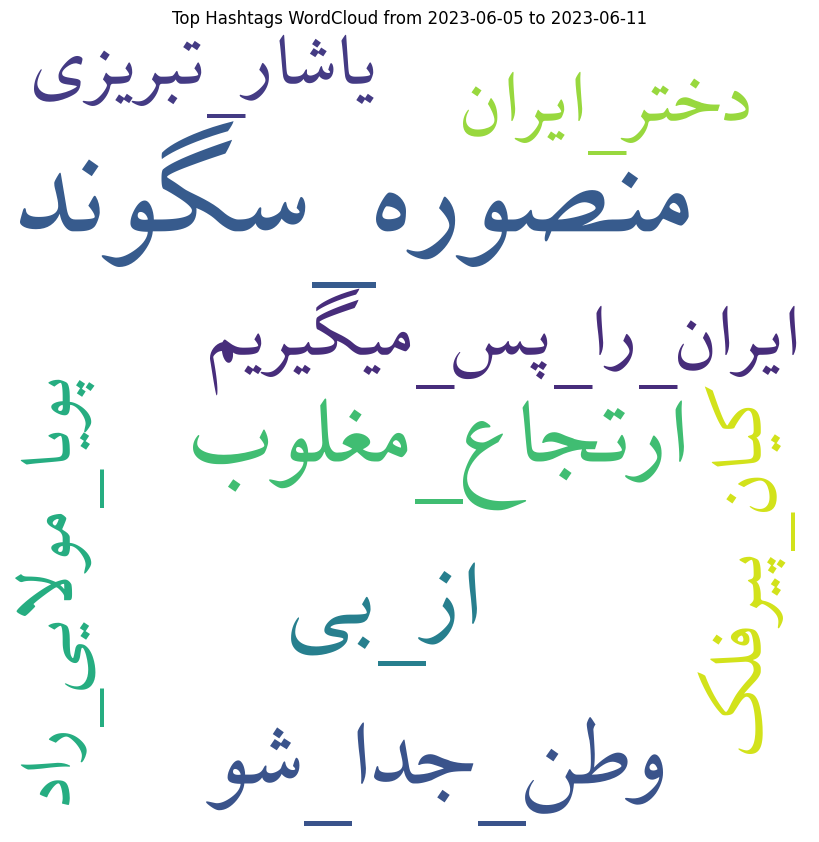

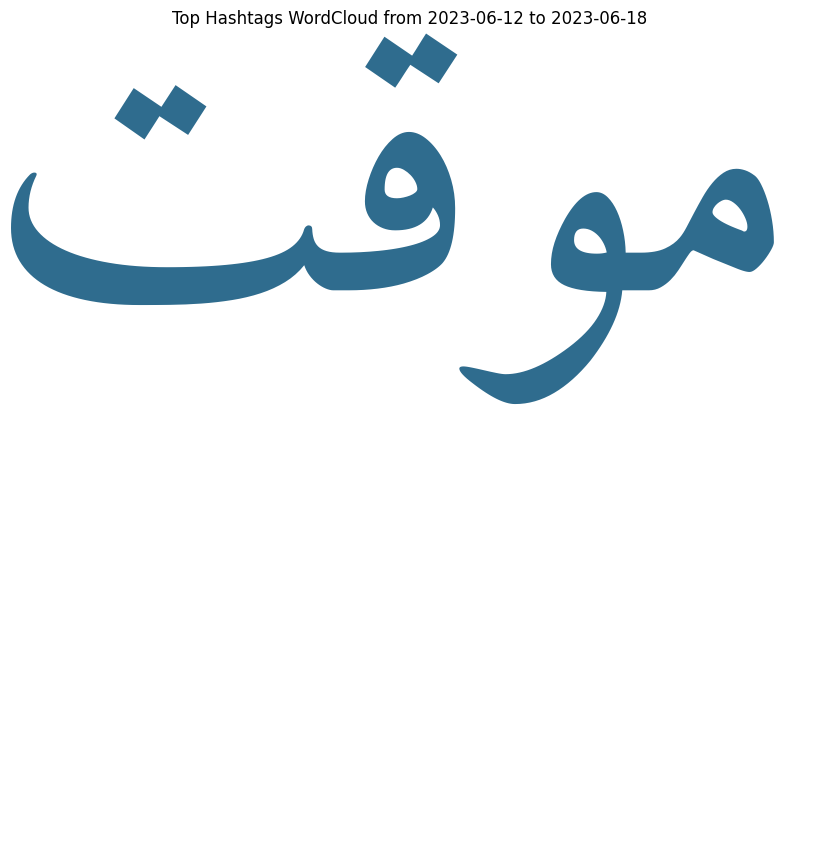

In [15]:
font_path ='/usr/share/fonts/TTF/XB-Zar-Regular.ttf'

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Convert year, month, and day columns to datetime
df["date"] = pd.to_datetime(df[["year", "month", "day"]])

# Split the dataframe into two based on the date
df_before = df[df["date"] < "2022-09-14"]
df_after = df[df["date"] >= "2022-09-14"]


# Group by month for the period before
df_before_grouped = df_before.groupby([df_before["date"].dt.year.rename("year"), df_before["date"].dt.month.rename("month"), "hashtag"])["count"].sum().reset_index()

# Group by week for the period after
df_after_grouped = df_after.groupby([df_after["date"].dt.to_period('W').rename("week"), "hashtag"])["count"].sum().reset_index()

# Function to generate and plot word cloud
def generate_word_cloud(df_grouped, time_period):
    for date, df in df_grouped.groupby(time_period):
        text = ' '.join(' '.join([hashtag]*count) for hashtag, count in zip(df["hashtag"], df["count"]))
        wordcloud = WordCloud(font_path, width = 800, height = 800, 
                              background_color ='white', 
                              stopwords = None, 
                              min_font_size = 14).generate(text)
        
        # Plot the word clouds
        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 

        # find next date, if weekly or year month its motnly
        # Determine start and end date of each period
        if isinstance(date, tuple):
            # Monthly
            start_date = f"{date[0]}-{date[1]}-01"
            start_date = pd.to_datetime(start_date)
            end_date = start_date + pd.offsets.MonthEnd(1)
        else:
            # Weekly
            start_date = date.start_time.date()
            end_date = date.end_time.date()

        # format dates to have {year}-{month}-{day} format
        start_date = start_date.strftime("%Y-%m-%d")
        end_date = end_date.strftime("%Y-%m-%d")

        plt.title(f"Top Hashtags WordCloud from {start_date} to {end_date}")
        plt.show()

# Generate word clouds
generate_word_cloud(df_before_grouped, ["year", "month"]) # for monthly
generate_word_cloud(df_after_grouped, "week") # for weekly


In [18]:
import imageio
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import io

# We'll store each frame of the gif in this list
frames = []

df = df[df["date"] < "2023-04-26"]
# Sort the DataFrame by date
df = df.sort_values(by='date')


# For each date
for date, df_date in df.groupby('date'):

    # Get the hashtags and counts for this date
    hashtags = df_date['hashtag']
    counts = df_date['count']
    
    # Generate the word cloud text
    text = ' '.join(' '.join([hashtag]*count) for hashtag, count in zip(hashtags, counts))
    
    # Generate the word cloud
    wordcloud = WordCloud(font_path=font_path, width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = None, 
                    min_font_size = 16).generate(text)
    
    # Display the generated image with matplotlib, save to a bytes buffer
    date_fmt = date.strftime("%Y-%m-%d")
    plt.title(f"Top Hashtags WordCloud on {date_fmt}")

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
            
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    
    # Add this frame to the list of frames
    frames.append(imageio.imread(buf))

    # Clear the matplotlib plot so the next one doesn't overlap
    plt.clf()

# Save frames as a mp4
imageio.mimsave('wordcloud.mp4', frames, fps=1) # 10 fps for smooth transition


/tmp/ipykernel_15291/1787477084.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(buf))


In [17]:
imageio.mimsave('wordcloud.mp4', frames, fps=10) # 10 fps for smooth transition
